In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import json
from sklearn.preprocessing import StandardScaler
from pandas.tseries.frequencies import to_offset
from torch import nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Sampler
from torch.utils.data.sampler import RandomSampler
import re
import pickle
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


import warnings
warnings.filterwarnings("ignore")

## Data Load

We load and process data from multiple sources. We begin by loading five years of ET data from 2018 to 2022,then we load lysimeter-specific covariate data for the year 2022 and adjust the timestamp format as necessary.

In [2]:
#loading 5 years ET for loam soil (soy crop) data
df_path_start = 'data2/'
df_path_end = '_loam_completeT.csv'
all5years=[]
for x in range(2018,2023): # 5 years data
    all5years.append(pd.read_csv(df_path_start+str(x)+df_path_end))
    print(all5years[x-2018].shape)

#loading lysimeter specific covariates data for year 2022 loam soil and changing the timestamp format
df_path_start = 'covar/'
df_path_end = '.csv'
fileNames = ['005','010','030','060','090']
allcovars = []
for x in fileNames: # covariates
    allcovars.append(pd.read_csv(df_path_start+x+df_path_end))

desired_format_str = "%Y-%m-%d %H:%M:%S"
for x in range(len(allcovars)):
    allcovars[x] = allcovars[x][5760:13105].reset_index(drop=True)
    allcovars[x]['timestamp'] = pd.to_datetime(allcovars[x]['timestamp'], format='%d-%m-%Y %H:%M')
    allcovars[x]['timestamp'] = allcovars[x]['timestamp'].dt.strftime(desired_format_str)
    print(allcovars[x].shape)

# there are extra instances in 2020!
all5years[2] = all5years[2][48:17568] 

# Work in progress to create a mask (Ignore)
all5yearsNulls = all5years.copy()
for x in range(len(all5years)):
    all5years[x].name = str(x)
    all5years[x] = all5years[x][5760:13105].reset_index(drop=True)
    all5years[x]['timestamp'] = pd.to_datetime(all5years[x]['timestamp'], format='%Y-%m-%d %H:%M:%S')
    print(all5years[x]['timestamp'].iloc[0], all5years[x]['timestamp'].iloc[-1])
    all5yearsNulls[x] = all5years[x].isnull()

(17520, 60)
(17520, 60)
(17568, 60)
(17520, 60)
(17520, 60)
(7345, 10)
(7345, 10)
(7345, 10)
(7345, 10)
(7345, 10)
2018-05-01 00:00:00 2018-10-01 00:00:00
2019-05-01 00:00:00 2019-10-01 00:00:00
2020-05-01 00:00:00 2020-10-01 00:00:00
2021-05-01 00:00:00 2021-10-01 00:00:00
2022-05-01 00:00:00 2022-10-01 00:00:00


Impute 2022 loam soil Lysimeter Data with IterativeImputer (MICE)

In [3]:
feats = ['timestamp', 'H1L1', 'H1L2', 'H1L6', 'H2L1', 'H2L3', 'H2L5', 'H3L2', 'H3L3', 'H3L4', 'Temp (Â°C)', 'Precip. Amount (mm)', 'Rel Hum (%)','Wind Spd (km/h)', 'Net_Radiation']
df = all5years[4][feats] # selecting year 2022
dfNull = all5yearsNulls[4][feats]
feats.remove('timestamp')

imputer = IterativeImputer(max_iter=100, random_state=42)
df[feats] = imputer.fit_transform(df[feats])
try:
    nullfeatures = (df.isnull().sum()).sort_values(ascending=0)
    nullfeatures = nullfeatures[nullfeatures>0]
    print(nullfeatures)
except:
    print("'numpy.ndarray' object has no attribute 'isnull'")

Series([], dtype: int64)


Impute 2022 loam soil Lysimeter Covariate Data with Rolling Means

In [4]:
tsd = allcovars[0]['timestamp']
for x in range(len(allcovars)):
    allcovars[x].drop(columns=['timestamp'],inplace=True)

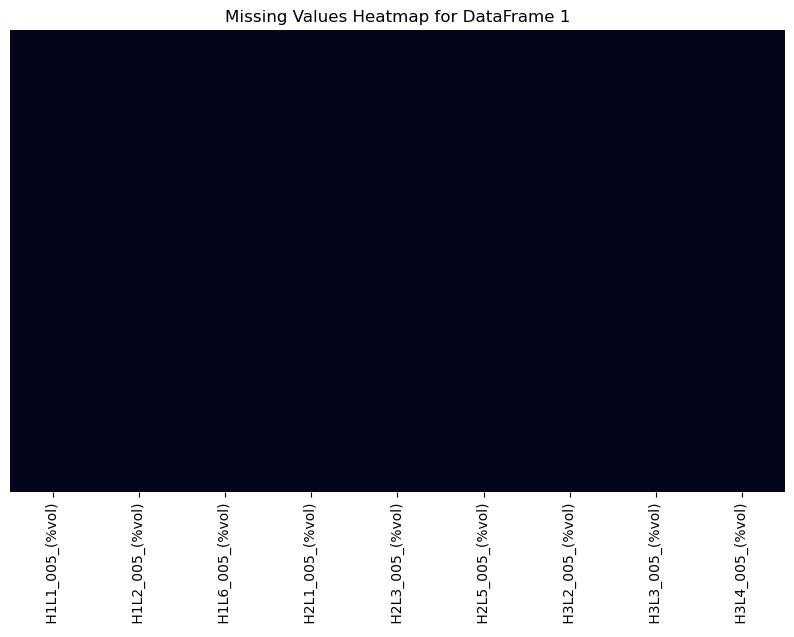

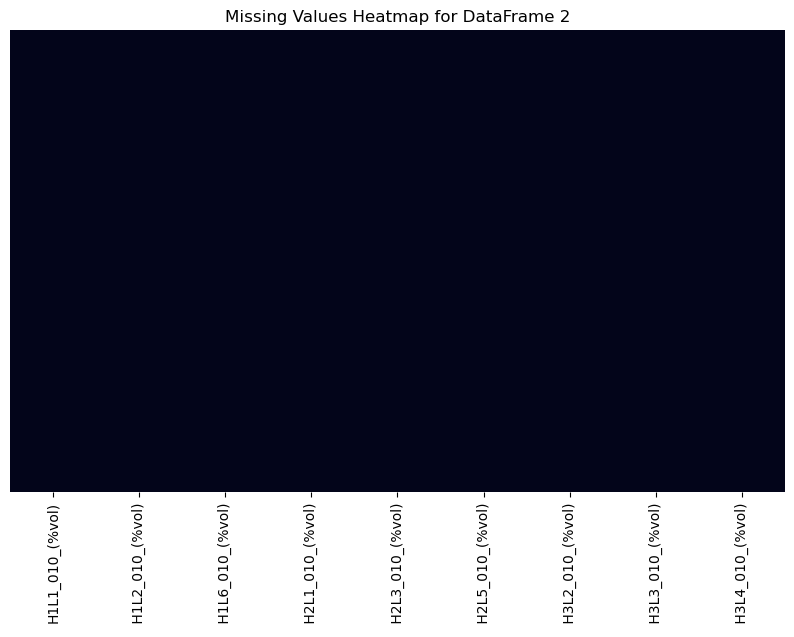

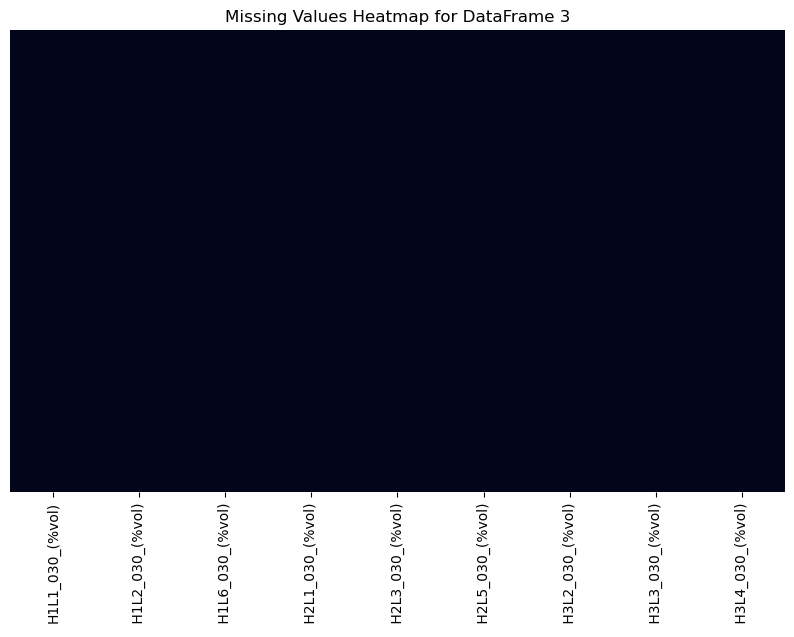

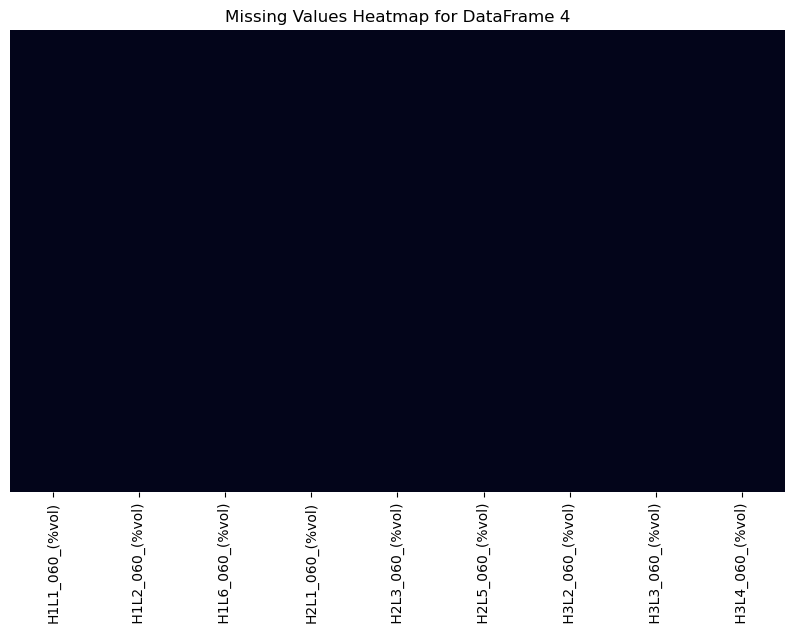

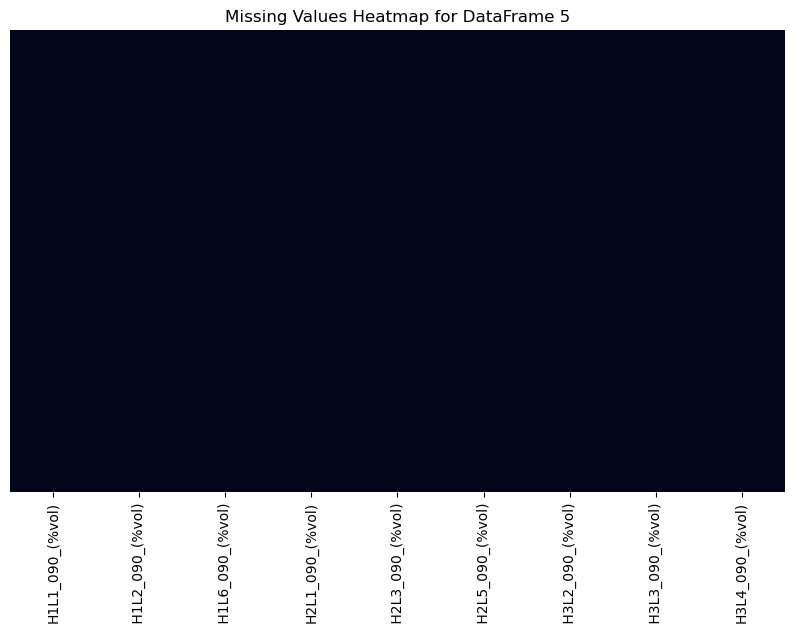

In [5]:
for i, pf in enumerate(allcovars):
    pf = pf.fillna(pf.rolling(window=48, min_periods=1).mean())
    pf = pf.fillna(pf.mean())
    for y in pf.columns:
        if pf[y].isna().any():
            pf[y]=pf.iloc[:,1]
    allcovars[i] = allcovars[i].fillna(0)

    plt.figure(figsize=(10, 6))
    sns.heatmap(pf.isnull(), yticklabels=False, cbar=False)
    plt.title(f"Missing Values Heatmap for DataFrame {i+1}")
    plt.show()

In [6]:
#checking if all covars are imputed
for x in range(len(allcovars)):
    allcovars[x]['timestamp']=tsd
    print(allcovars[x].isna().any())

 H1L1_005_(%vol)    False
 H1L2_005_(%vol)    False
 H1L6_005_(%vol)    False
 H2L1_005_(%vol)    False
 H2L3_005_(%vol)    False
 H2L5_005_(%vol)    False
 H3L2_005_(%vol)    False
 H3L3_005_(%vol)    False
 H3L4_005_(%vol)    False
timestamp           False
dtype: bool
H1L1_010_(%vol)     False
 H1L2_010_(%vol)    False
 H1L6_010_(%vol)    False
 H2L1_010_(%vol)    False
 H2L3_010_(%vol)    False
 H2L5_010_(%vol)    False
 H3L2_010_(%vol)    False
 H3L3_010_(%vol)    False
 H3L4_010_(%vol)    False
timestamp           False
dtype: bool
H1L1_030_(%vol)     False
 H1L2_030_(%vol)    False
 H1L6_030_(%vol)    False
 H2L1_030_(%vol)    False
 H2L3_030_(%vol)    False
 H2L5_030_(%vol)    False
 H3L2_030_(%vol)    False
 H3L3_030_(%vol)    False
 H3L4_030_(%vol)    False
timestamp           False
dtype: bool
H1L1_060_(%vol)     False
 H1L2_060_(%vol)    False
 H1L6_060_(%vol)    False
H2L1_060_(%vol)     False
 H2L3_060_(%vol)    False
 H2L5_060_(%vol)    False
 H3L2_060_(%vol)    False
 H

Plotting entire Growing season 2022 year data for ET for H1L1 Lysimeter

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


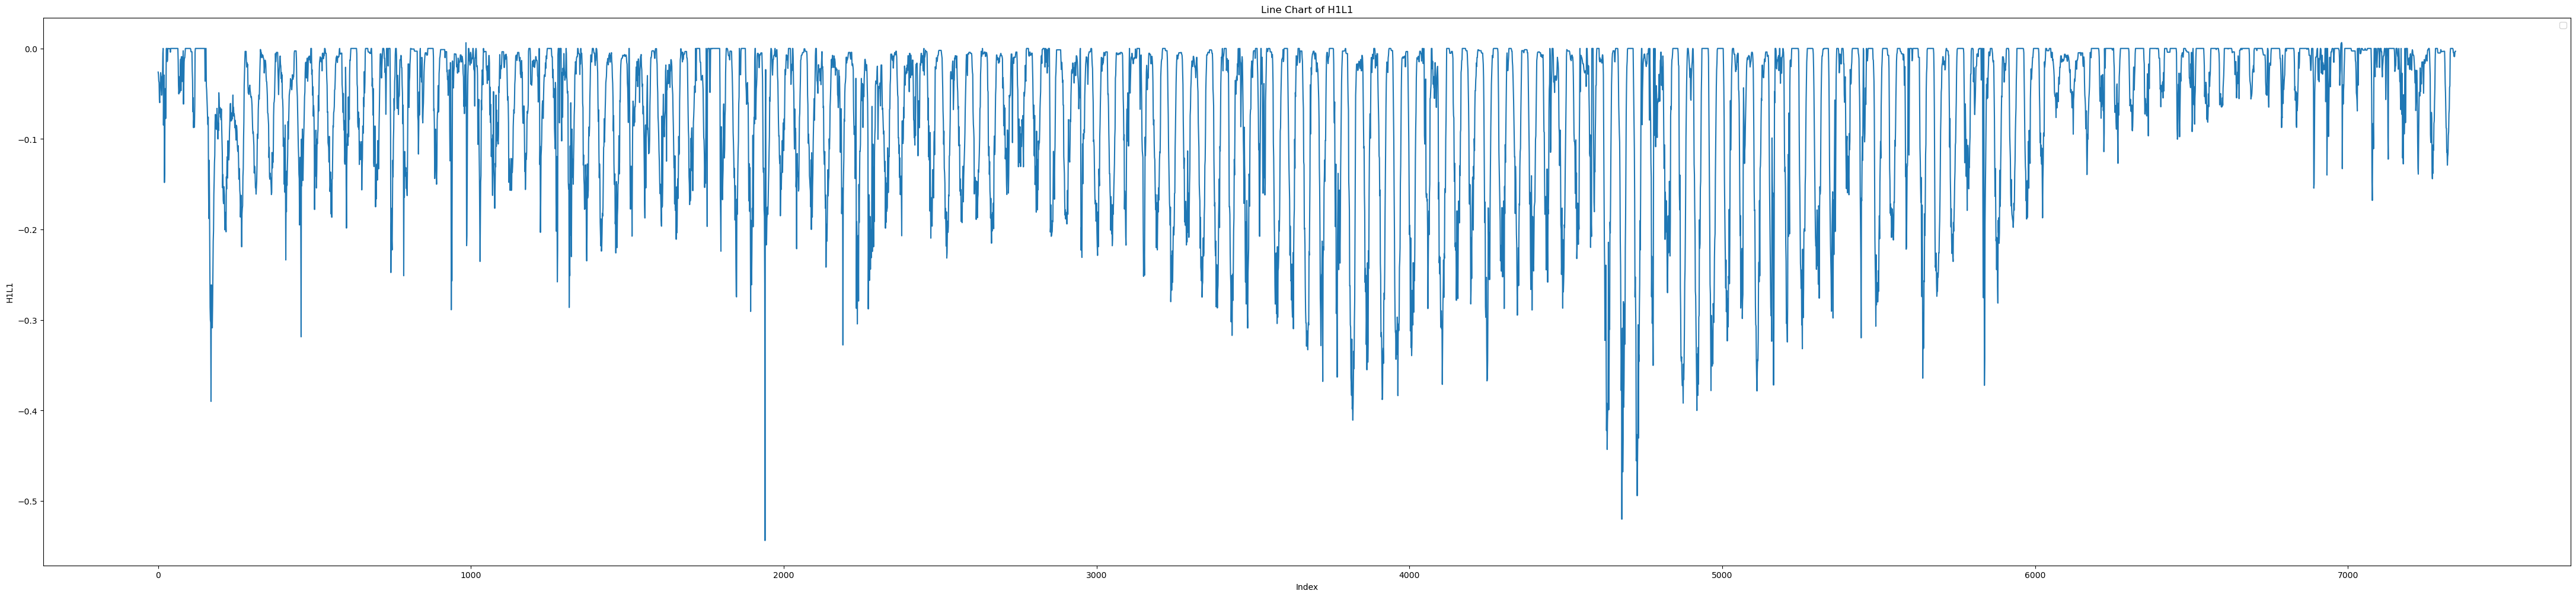

In [7]:
plt.figure(figsize=(55, 12))
plt.plot(df['H1L1']) 
plt.xlabel('Index')
plt.ylabel('H1L1')
plt.title(f'Line Chart of H1L1')
plt.legend()
plt.show()

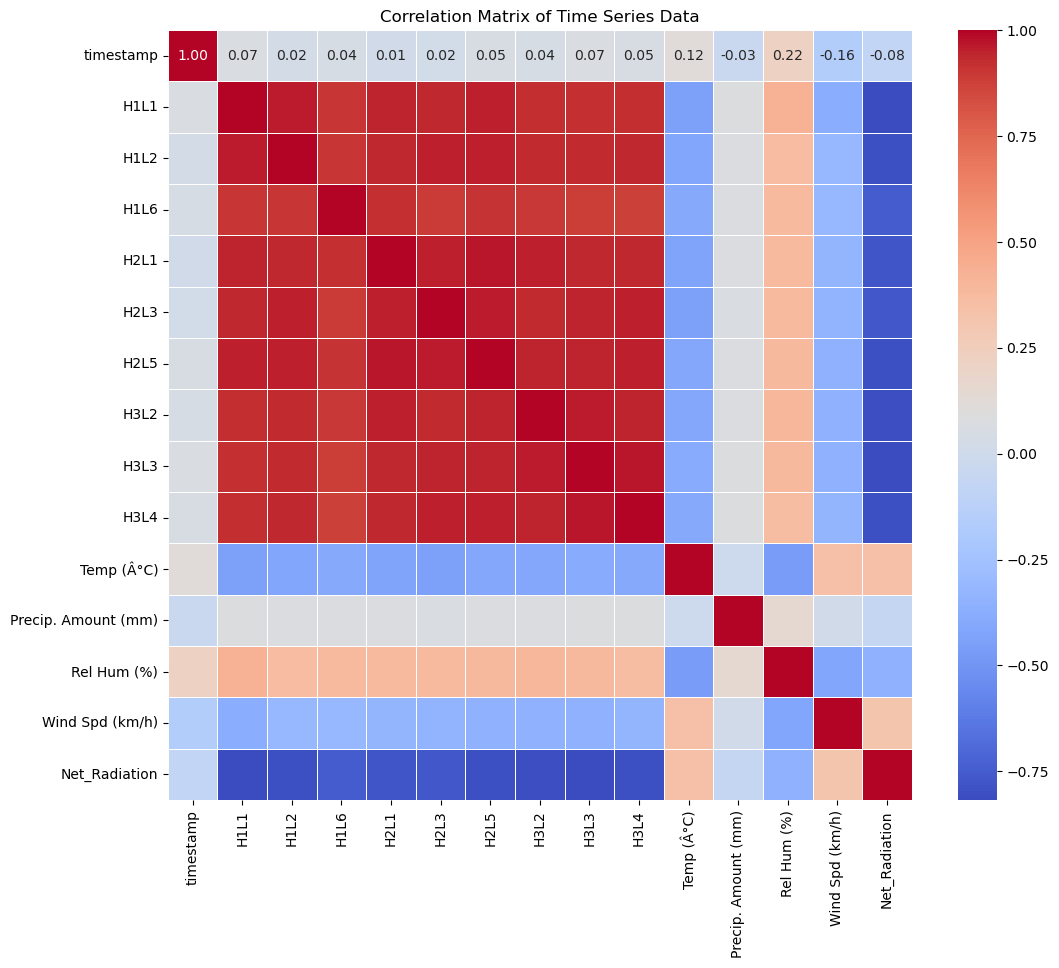

In [8]:
correlation_matrix = df.corr()
# plotting the correlation matrix 
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Time Series Data')
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7345 entries, 0 to 7344
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            7345 non-null   datetime64[ns]
 1   H1L1                 7345 non-null   float64       
 2   H1L2                 7345 non-null   float64       
 3   H1L6                 7345 non-null   float64       
 4   H2L1                 7345 non-null   float64       
 5   H2L3                 7345 non-null   float64       
 6   H2L5                 7345 non-null   float64       
 7   H3L2                 7345 non-null   float64       
 8   H3L3                 7345 non-null   float64       
 9   H3L4                 7345 non-null   float64       
 10  Temp (Â°C)           7345 non-null   float64       
 11  Precip. Amount (mm)  7345 non-null   float64       
 12  Rel Hum (%)          7345 non-null   float64       
 13  Wind Spd (km/h)      7345 non-nul

Creating two datasets: smoothed and unsmooth data

In [10]:
tseries = ['H1L1', 'H1L2', 'H1L6', 'H2L1', 'H2L3', 'H2L5', 'H3L2', 'H3L3', 'H3L4', 'timestamp']

def moving_average(data, window_size=4):
    return data.rolling(window=window_size, min_periods=1).mean()
print(df[tseries].shape)

smoothed_df = df[tseries].copy()  #a copy of the original dataframe to store smoothed data
for col in df[tseries].columns:
    if col != 'timestamp':
        smoothed_df[col] = moving_average(df[col])

print(smoothed_df.shape)

df.to_csv('unsmooth-2018-ET.csv')
smoothed_df.to_csv('2018-ET.csv')

tseries = ['H1L1', 'H1L2', 'H1L6', 'H2L1', 'H2L3', 'H2L5', 'H3L2', 'H3L3', 'H3L4']
covariatesOG1 = df.drop(columns=tseries)
covariatesOG1.to_csv('covariatesOG.csv')

for i, pf in enumerate(allcovars):
    pf.to_csv(str(i)+'.csv')

(7345, 10)
(7345, 10)


## Data Preprocess

adds time-related covariates (like weekday, hour, month) to the covariates present in a DataFrame and returns the resulting covariates array. these covariates are common to all time series data

In [11]:
def gen_covariates(df_covar,times):
	num_covariates_time = 3
	total_covariates = num_covariates_time + len(df_covar.columns)

	covariates = np.zeros((times.shape[0], num_covariates_time))
	for i, input_time in enumerate(times):
		covariates[i, 0] = input_time.weekday()
		covariates[i, 1] = input_time.hour
		covariates[i, 2] = input_time.month

	og_Vals = df_covar.values
	covariates = np.hstack((og_Vals,covariates))
	print('Covariates Generation',covariates.shape,df_covar.shape)
	return covariates[:, :total_covariates]

function that organizes the data into a suitable format for training the cov. trans. model while also performing necessary scaling and normalization on both the time series data and any associated covariates

In [12]:
def prep_data(data, window_size, stride_size, data_start, timeseries_list, covariates=None, covariates_var=None, transformation_covariates_used=None, transformation_covariates_var_used=None):
    # data shape information
    time_len, num_series = data.shape[0], data.shape[1]
    input_size = window_size - stride_size

    # Verification
    if not covariates_var is None :
		# Verification of index matching
        assert covariates_var.shape[0] == data.shape[0]
		# Verification of time series matching
        assert covariates_var.shape[1] == data.shape[1]

    if not covariates is None :
		# Verification of index matching
        assert covariates.shape[0] == data.shape[0]

    # retaining only series section that do not start with non null values 
    kept_timeseries = time_len - data_start > window_size
    data = data[:,kept_timeseries]
    data_start = data_start[kept_timeseries]
    covariates_var = None if covariates_var is None else covariates_var[:,kept_timeseries,:]
    timeseries_list = timeseries_list[kept_timeseries]

    time_len = data.shape[0]-1
    num_cov_simple = 0 if covariates is None else covariates.shape[1]
    num_cov_var = 0 if covariates_var is None else covariates_var.shape[2]
    num_covariates = num_cov_simple + num_cov_var

    dict_timeseries = dict(zip(timeseries_list, range(num_series)))

    # Number of Windows
    windows_per_series = ((time_len - input_size) // stride_size) - (data_start + stride_size - 1) // stride_size

    # Data structure definition
    total_windows = np.sum(windows_per_series)
    print(f'windows_per_series: {windows_per_series}, total_windows: {total_windows}, window_size: {window_size}, 1 + num_covariates + 1:{1 + num_covariates + 1}')

    x_input = np.zeros((total_windows, window_size, 1 + num_covariates + 1), dtype='float32')
    label = np.zeros((total_windows, window_size), dtype='float32')
    v_input = np.zeros((total_windows, 2), dtype='float32')

    # Saving Transformation instances in Dictionaries so that that they can be used to scale the test data
    transformation_covariates_var = {}
    transformation_covariates = {}

    if covariates_var is not None:
        covariates_var = covariates_var.astype(float)

    if covariates is not None:
        covariates = covariates.astype(float)

    # Scaling the covariates (temperature, net radiation,etc)
    for i in range(num_cov_simple):
        if transformation_covariates_used is None and covariates is not None:
            transformer_cov_simple = StandardScaler()
            covariates[:, i] = transformer_cov_simple.fit_transform(covariates[:, i].reshape(-1, 1))[:, 0]
            transformation_covariates[i] = transformer_cov_simple
        elif covariates is not None:
            transformer_cov_simple = transformation_covariates_used[i]
            covariates[:, i] = transformer_cov_simple.transform(covariates[:, i].reshape(-1, 1))[:, 0]
            transformation_covariates[i] = transformer_cov_simple

    count=0
    # Scaling the covariate variables
    for series in range(num_series): #9
        # Scaling the lysimeter specific covariate  variables (Soil Moisture)
        if transformation_covariates_var_used is None and not covariates_var is None:
			# creating a scaler instance
            transfomer_cov_var = StandardScaler()
            covariates_var[data_start[series]:, series,:] = transfomer_cov_var.fit_transform(covariates_var[data_start[series]:, series,:])
        elif not covariates_var is None:
		    # loading the used one for example in the training
            transfomer_cov_var = transformation_covariates_var_used[series]
            covariates_var[data_start[series]:, series,:] = transfomer_cov_var.transform(covariates_var[data_start[series]:, series,:])

        if not covariates_var is None:
            transformation_covariates_var[series] = transfomer_cov_var

        # Windows creation
        for i in range(windows_per_series[series]):
            window_start = stride_size * i + data_start[series]
            window_end = window_start + window_size

            x_input[count, :, 0] = data[window_start:window_end, series] # timeseries value; we start always by 0
            x_input[count, :, 1:1+num_cov_simple] = 0 if num_cov_simple==0 else covariates[window_start+1:window_end+1, :] # covariates_values (Temperature, windspeed, net radiation)
            x_input[count, :, 1+num_cov_simple:-1] = 0 if num_cov_var == 0 else covariates_var[window_start+1:window_end+1, series,:] # covariates that depend on the time series (Soild Moisture)
            x_input[count, :, -1] = series

            # Assign label
            label[count, :] = data[window_start + 1:window_end + 1, series]

            # Calculate normalisation factor
            nonzero_sum = (x_input[count, :, 0] != 0).sum()
            if nonzero_sum == 0:
                v_input[count, 0] = 1
            else:
                v_input[count, 0] = np.true_divide(x_input[count, :, 0].sum(), nonzero_sum) + 1
                x_input[count, :, 0] = x_input[count, :, 0] / v_input[count, 0]
                label[count, :] = label[count, :] / v_input[count, 0]

            count += 1

    return x_input, label, v_input, dict_timeseries, transformation_covariates_var, transformation_covariates

saves everything! Also creates 3 dicionaries called the meta information (data about training and testing indices and their scaling information), model configuration (data regarding model architecture) and training configuration (data regarding model training setup) 

In [13]:
def save_dataset(save_path,save_name,xtrain_input,v_input_train,label_train,timeseries_dict_train,transformation_covariates_var, transformation_covariates,xtest_input,v_input_test,label_test,timeseries_dict_test, split_dates):

	# saving train sets
	prefix = os.path.join(save_path, 'train_')

	np.save(prefix+'data_'+save_name, xtrain_input)
	np.save(prefix+'v_'+save_name, v_input_train)
	np.save(prefix+'label_'+save_name, label_train)
	np.save(prefix+'timeseries_dict_'+save_name, timeseries_dict_train)

	# saving test sets
	prefix = os.path.join(save_path, 'test_')
	np.save(prefix+'data_'+save_name, xtest_input)
	np.save(prefix+'v_'+save_name, v_input_test)
	np.save(prefix+'label_'+save_name, label_test)
	np.save(prefix+'timeseries_dict_'+save_name, timeseries_dict_test)

	# saving transformation
	with open(save_path+'/transformation_covariates_var_'+save_name+'.pkl', 'wb') as file:
		pickle.dump(transformation_covariates_var, file, pickle.HIGHEST_PROTOCOL)

	with open(save_path+'/transformation_covariates_'+save_name+'.pkl', 'wb') as file:
		pickle.dump(transformation_covariates, file, pickle.HIGHEST_PROTOCOL)

	# saving meta information
	num_timeseries_kinds = len(timeseries_dict_train)

	window_size = xtrain_input.shape[1]
	number_of_vars = xtrain_input.shape[2]-1

	meta_information = dict({
		'num_timeseries_kinds' : num_timeseries_kinds,
		'window_size' : window_size,
		'number_of_vars' : number_of_vars,
		})
	train_start,train_end,test_start,test_end = split_dates

	meta_information['transformation_covariates_var_path'] = save_path+'/transformation_covariates_var_'+save_name+'.pkl'
	meta_information['transformation_covariates'] = save_path+'/transformation_covariates_'+save_name+'.pkl'

	meta_information['train_start'] = str(train_start)
	meta_information['train_end'] = str(train_end)
	meta_information['test_start'] = str(test_start)
	meta_information['test_end'] = str(test_end)

	with open(save_path+'/meta_information.json', 'w') as file:
		json.dump(meta_information, file)

	#  model configuration
	model_config = dict()
	model_config['headers'] = 1#8 #6#3
	model_config['depth'] = 1#3 #5
	model_config['kernel_size'] = 4#10 #12
	model_config['default'] = True

	config_folder_path = os.path.join('models',save_name)
	os.makedirs(config_folder_path, exist_ok=True)

	config_path = os.path.join(config_folder_path,'model_config.json')

	with open(config_path, 'w') as file:
		json.dump(model_config, file)

	# training configuration
	train_config = dict()
	train_config['num_epochs'] = 500 #1000
	train_config['lr_warmup'] = 50 #100
	train_config['learning_rate'] =  0.005 #01
	train_config['default'] = False
	train_config['batch_size']  = 32 #32
	train_config['predict_batch_size'] = 32 #32

	train_path = os.path.join(config_folder_path,'train_config.json')
	with open(train_path, 'w') as file:
		json.dump(train_config, file)

pipeline for preparing time series data and covariates for training a forecasting model. handles tasks such as data loading, splitting, transformation, and saving.

In [185]:
def main(data_path, df_covar, data_covariates_path, date_column, cast_float16, window_size, stride_size, test_ratio, save_name):
    # Read ET Data
    print('Reading ET Data:')
    Table = pd.read_csv(data_path)
    try:
        Table.drop(columns=['Unnamed: 0'], inplace=True)
    except:
        pass
    Table[date_column] = pd.to_datetime(Table[date_column])
    Table.set_index(date_column, inplace=True)
    df_covar.set_index(date_column, inplace=True)

    print('Data loaded from : ' + data_path)
    print('Data Shape: ', Table.shape)
    print('OG Covariate Shape: ', df_covar.shape)

    if data_covariates_path:
        print('Reading Covariates Data:')
        covariates_var = []
        for file in os.listdir(data_covariates_path):
            if file.endswith(".csv"):
                if date_column :
                    var = pd.read_csv(data_covariates_path+'/'+file)
                    try:
                        var.drop(columns=['Unnamed: 0'], inplace=True)
                    except:
                        pass
                    var[date_column] = pd.to_datetime(var[date_column])
                    var.set_index(date_column, inplace=True)
                    covariates_var.append(var)
                else :
                    var = pd.read_csv(data_covariates_path+'/'+file, index_col = 0, parse_date=True)
                    covariates_var.append(var)
    else :
        covariates_var = None

    print('# Preparing the data :')
    print("\t # Window_size :", window_size)
    print("\t # Stride_size :", stride_size)
    print("\t # test_ratio :", test_ratio)

    l_total = len(Table)

    # Train and Test split. Splitting data by 0.8,0.2 for train and test
    train_start = Table.index[0]
    train_end = Table.index[int(l_total * (1 - test_ratio))]

    test_start = Table.index[int(l_total * (1 - test_ratio))]
    test_end = Table.index[-1]

    # List of time series
    timeseries_list = Table.columns

    train_data = Table.loc[train_start:train_end].values
    test_data = Table.loc[test_start:test_end].values
    print('Train Data shape: ', train_data.shape)
    print('Test Data shape: ', test_data.shape)

    print('\t #train_data index range:', train_start, train_end)
    print('\t #test_data index range:', test_start, test_end)


    #separating train and test covariates
    if not covariates_var is None :
        train_covariates_var = []
        for var in covariates_var :
            train_covariates_var.append(var.loc[train_start:train_end].values[:,:,None])
        train_covariates_var = np.concatenate(train_covariates_var,axis=2)

        test_covariates_var = []
        for var in covariates_var :
            test_covariates_var.append(var.loc[test_start:test_end].values[:,:,None])
        test_covariates_var = np.concatenate(test_covariates_var,axis=2)

    else :
        train_covariates_var = None
        test_covariates_var = None
    

    # generate covariates
    covariates_train = gen_covariates(df_covar.loc[train_start:train_end], Table.loc[train_start:train_end].index)
    covariates_test = gen_covariates(df_covar.loc[test_start:test_end], Table.loc[test_start:test_end].index)

    print('\n# Covariate variables prepared')

    # data_start
    data_start_train = (train_data != 0).argmax(axis=0)  # find first nonzero value in each time series
    data_start_test = (test_data != 0).argmax(axis=0)  # find first nonzero value in each time series

    # Apply the transformation
    print('\n# Data Scaling and Windows Creation:')

    window_size_train = window_size
    window_size_test = window_size
    print('# Training')
    xtrain_input, label_train, v_input_train, timeseries_dict_train, transformation_covariates_var, transformation_covariates = prep_data(train_data, window_size=window_size_train, stride_size=stride_size, data_start=data_start_train, timeseries_list=timeseries_list, covariates=covariates_train, covariates_var= train_covariates_var)
    print('# Testing')
    xtest_input, label_test, v_input_test, timeseries_dict_test, _, _ = prep_data(test_data, window_size=window_size_test, stride_size=stride_size, data_start=data_start_test, timeseries_list=timeseries_list, covariates=covariates_test, covariates_var=test_covariates_var,transformation_covariates_used = transformation_covariates, transformation_covariates_var_used = transformation_covariates_var)

    #Saving
    save_path = 'data_prepared/'
    os.makedirs(save_path+save_name, exist_ok = True)
    save_path = save_path+save_name

    print('\nSaving the data!')
    print('\t # Used save_name:',save_name)
    save_dataset(save_path,save_name,xtrain_input,v_input_train,label_train,timeseries_dict_train,transformation_covariates_var, transformation_covariates,xtest_input,v_input_test,label_test,timeseries_dict_test, [train_start,train_end,test_start,test_end])


data_path = '2018-ET.csv'
data_covariates_path = None#'prep_covar'
date_column = 'timestamp'
cast_float16 = False
covariatesOG = covariatesOG1.copy()

window_size = 48
stride_size = 3
test_ratio = 0.22
save_name = 'ET_prep'

main(data_path, covariatesOG, data_covariates_path, date_column, cast_float16, window_size, stride_size, test_ratio, save_name)

Reading ET Data:
Data loaded from : 2018-ET.csv
Data Shape:  (7345, 9)
OG Covariate Shape:  (7345, 5)
# Preparing the data :
	 # Window_size : 48
	 # Stride_size : 3
	 # test_ratio : 0.22
Train Data shape:  (5730, 9)
Test Data shape:  (1616, 9)
	 #train_data index range: 2022-05-01 00:00:00 2022-08-28 08:30:00
	 #test_data index range: 2022-08-28 08:30:00 2022-10-01 00:00:00
Covariates Generation (5730, 8) (5730, 5)
Covariates Generation (1616, 8) (1616, 5)

# Covariate variables prepared

# Data Scaling and Windows Creation:
# Training
windows_per_series: [1894 1894 1894 1894 1893 1894 1894 1893 1893], total_windows: 17043, window_size: 48, 1 + num_covariates + 1:10
# Testing
windows_per_series: [523 523 523 523 523 523 523 523 523], total_windows: 4707, window_size: 48, 1 + num_covariates + 1:10

Saving the data!
	 # Used save_name: ET_prep


loss evaluation! we use quantile loss

In [14]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles

    def forward(self, target, preds_down,preds_middle,preds_up):
        preds = torch.cat([preds_down,preds_middle,preds_up], axis=2)
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target[:,:,0] - preds[:,:,i]
            losses.append(
                torch.max(
                   (q-1) * errors,
                   q * errors
            ).unsqueeze(1))
        loss = torch.mean(
            torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

def loss_fct(mu, sigma, labels, loss_kind):
    if loss_kind=='nll_dist_normal':
        indices= (labels != 0)
        log_likelihood = torch.distributions.Normal(mu[indices], sigma[indices]).log_prob(labels[indices])
        loss = -log_likelihood.mean()
    elif loss_kind  == 'nll_dist_lognormal':
        indices= (labels != 0)
        log_likelihood = torch.distributions.log_normal.LogNormal(mu[indices], sigma[indices]).log_prob(labels[indices])
        loss = -log_likelihood.mean()
    elif loss_kind == 'quantileloss_dist_normal':
        lossQ = QuantileLoss([0.1587,0.5,0.8413])
        preds_middle = mu
        preds_downs =  preds_middle - sigma
        preds_up = preds_middle + sigma
        loss = lossQ(labels[:,:,None],preds_downs,preds_middle,preds_up)
    return loss


def evaluate(model, x_test, tokens_tst_idx, v_tst, windows_size, sampling = False, number_of_samples = 100, scaled_param = False):
    """
    Function to apply the model on a batch and get the evaluation
    model : The model to use for the evaluation
    x_test: 3D array,
    tokens_tst_idx, v_tst, windows_size, sampling = False, number_of_samples = 100, scaled_param = False

    """
    batch_size = x_test.shape[0]
    # v_tst is expanded, which means it has the shape (batch_size, windows_size, 2)

    if sampling :
        # Sample from the distribution to estimate
        samples = torch.empty((number_of_samples,batch_size, windows_size,1))

        # Distribution parameters
        mu, sigma = model(x = x_test, tokens = tokens_tst_idx)

        scaled_mu = mu[:,:,0] * v_tst[:,:,0] + v_tst[:,:,1]
        scaled_mu = scaled_mu[:,:,None]

        scaled_sigma = sigma[:,:,0] * v_tst[:,:,0]
        scaled_sigma = scaled_sigma[:,:,None]

        # Sampling loop
        distributions = torch.distributions.log_normal.LogNormal(mu, sigma)
        for k in range(number_of_samples):
            sample = distributions.sample()
            if scaled_param :
                sample = sample[:,:,0]* v_tst[:,:,0] + v_tst[:,:,1]
            sample = sample[:,:,None]
            samples[k,:,:] = sample

        estimation = samples.median(dim=0)[0] * v_tst[:,:,:1] + v_tst[:,:,1:]

        if scaled_param :
            return samples, estimation, scaled_mu,scaled_sigma
        else :
            return samples, estimation, mu, sigma

    else:
        # Distribution parameters
        mu, sigma = model(x = x_test, tokens = tokens_tst_idx)

        scaled_mu = mu[:,:,0] * v_tst[:,:,0] + v_tst[:,:,1]
        scaled_mu = scaled_mu[:,:,None]

        scaled_sigma = sigma[:,:,0] * v_tst[:,:,0]
        scaled_sigma = scaled_sigma[:,:,None]

        if scaled_param :
            estimation = scaled_mu
        else:
            estimation = mu
        return estimation, scaled_mu, scaled_sigma


def test_evaluation(model,X_tst_check, tokens_tst_idx, v_tst, labels_tst, windows_size, first_affect=False, sampling=True, number_of_samples=25,loss_kind = 'nll_dist_normal'):
    """
    Function to compute the predictions and the losses for the test batchs
    # X_tst_check :  (batch, global_window, vars) : the batch to manage
    # tokens_tst_idx : (batch,) : The list of tokens of the batchs
    # v_tst :  (batch,2) :  The scale of serie for each batch
    # labels_tst : The serie to predict
    # windows_size: The model window size
    # first_affect : {True, False} : To make the next prediction based on the first window predicted values or not (using the authentic ones)
    # sampling : {True, False} : To make predictions based on samling or not (the mean of the distribution is used)
    # number_of_samples : If using sampling, the number of samples

    returns :
    # predicted_serie :  (batch, global_window, 1) : The predicted serie
    # v_tst :  (batch,2) :  The scale of serie for each batch
    # labels_tst : (batch, global_window) : The true value of the serie
    # tst_loss : the mean loss
    # mus : (windows_total,batch,window_size,1) : The predicted unscaled mean predicted by the model
    # sigmas : (windows_total,batch,window_size,1) : The predicted unscaled sigma predicted by the model
    """

    # Parameters :
    tst_global_window_size = X_tst_check.shape[1] # which is the train_windows_size that come in the batch == 62
    batch_size = X_tst_check.shape[0]
    stride = 1 # it's 1 to predict next step, if not (e.g 4), there would be stride-1 (e.g 4-1) instant not predicted each time
    windows_total = (tst_global_window_size - (windows_size-stride))//stride # total number of windows

    # Evaluation :
    sampling = sampling
    number_of_samples = number_of_samples

    st = 0
    nd = st + windows_size

    mus = torch.empty((int(windows_total),batch_size, windows_size,1))
    sigmas= torch.empty((int(windows_total),batch_size, windows_size,1))

    predicted_serie = torch.empty((batch_size, tst_global_window_size,1))


    for i in range(int(windows_total)):

        # Xtest extraction
        x_test = X_tst_check[:,st:nd,:]

        # Model application :

        ### Expand the v_tst to the shape (batch, windows_size,2), since the scale is the same  for all instants in the window (due to the small size difference between the learning window and the test window)
        v_tst_expanded = v_tst.expand(windows_size,batch_size,2).transpose(1,0)
        if sampling:
            samples, estimation, mu, sigma = evaluate(model, x_test, tokens_tst_idx, v_tst_expanded, windows_size,
                                     sampling, number_of_samples)
        else:
            estimation, mu, sigma = evaluate(model, x_test, tokens_tst_idx, v_tst_expanded, windows_size,
                                     sampling, number_of_samples)
        # mu & sigma history
        mus[i,:,:,:] = mu
        sigmas[i,:,:,:] = sigma

        # Changing the value in the X_tst to the predicted next value to make next prediction:

        if i == 0 and first_affect: # the first window, we affect all the predicted elements, so next prediction would be based on those
            X_tst_check[:,st:nd,0] = estimation[:,st:nd,0]

        if nd < tst_global_window_size :
            X_tst_check[:,nd,0] = estimation[:,-1,0]

        # Predicted elements :

        if i == 0 :
            predicted_serie[:,st:nd,0] = estimation[:,st:nd,0] # predicted affected

        if nd < tst_global_window_size :
            predicted_serie[:,nd,0] = estimation[:,-1,0]

        # Loss calculation :
        tst_loss = loss_fct(mu, sigma, labels_tst[:,st:nd],loss_kind)
        st+=stride
        nd+=stride

    tst_loss = tst_loss/int(windows_total)
    return predicted_serie, v_tst, labels_tst, tst_loss, mus, sigmas

neural network model

In [15]:
# Self Attention Class
class SelfAttentionConv(nn.Module):
    def __init__(self, k, headers = 8, kernel_size = 5, mask_next = True, mask_diag = False):
        super().__init__()

        self.k, self.headers, self.kernel_size = k, headers, kernel_size
        self.mask_next = mask_next
        self.mask_diag = mask_diag

        h = headers

        # Query, Key and Value Transformations

        padding = (kernel_size-1)
        self.padding_opertor = nn.ConstantPad1d((padding,0), 0)

        self.toqueries = nn.Conv1d(k, k*h, kernel_size, padding=0 ,bias=True)
        self.tokeys = nn.Conv1d(k, k*h, kernel_size, padding=0 ,bias=True)
        self.tovalues = nn.Conv1d(k, k*h, kernel_size = 1 , padding=0 ,bias=False) # No convolution operated

        # Heads unifier
        self.unifyheads = nn.Linear(k*h, k)

    def forward(self, x):

        # Extraction dimensions
        b, t, k  = x.size() # batch_size, number_of_timesteps, number_of_time_series


        # Checking Embedding dimension
        assert self.k == k, 'Number of time series '+str(k)+' didn t much the number of k '+str(self.k)+' in the initiaalization of the attention layer.'
        h = self.headers

        #  Transpose to see the different time series as different channels
        x = x.transpose(1,2)
        x_padded = self.padding_opertor(x)

        # Query, Key and Value Transformations
        queries = self.toqueries(x_padded).view(b,k,h,t)
        keys = self.tokeys(x_padded).view(b,k,h,t)
        values = self.tovalues(x).view(b,k,h,t)

        # Transposition to return the canonical format
        queries = queries.transpose(1,2) # batch, header, time serie, time step (b, h, k, t)
        queries = queries.transpose(2,3) # batch, header, time step, time serie (b, h, t, k)

        values = values.transpose(1,2) # batch, header, time serie, time step (b, h, k, t)
        values = values.transpose(2,3) # batch, header, time step, time serie (b, h, t, k)

        keys = keys.transpose(1,2) # batch, header, time serie, time step (b, h, k, t)
        keys = keys.transpose(2,3) # batch, header, time step, time serie (b, h, t, k)


        # Weights
        queries = queries/(k**(.25))
        keys = keys/(k**(.25))

        queries = queries.transpose(1,2).contiguous().view(b*h, t, k)
        keys = keys.transpose(1,2).contiguous().view(b*h, t, k)
        values = values.transpose(1,2).contiguous().view(b*h, t, k)


        weights = torch.bmm(queries, keys.transpose(1,2))


        ## Mask the upper & diag of the attention matrix
        if self.mask_next :
            if self.mask_diag :
                indices = torch.triu_indices(t ,t , offset=0)
                weights[:, indices[0], indices[1]] = float('-inf')
            else :
                indices = torch.triu_indices(t ,t , offset=1)
                weights[:, indices[0], indices[1]] = float('-inf')

        # Softmax
        weights = F.softmax(weights, dim=2)

        # Output
        output = torch.bmm(weights, values)
        output = output.view(b,h,t,k)
        output = output.transpose(1,2).contiguous().view(b,t, k*h)

        return self.unifyheads(output) # shape (b,t,k)


# Conv Transforme Block
class ConvTransformerBLock(nn.Module):
    def __init__(self, k, headers, kernel_size = 5, mask_next = True, mask_diag = False, dropout_proba = 0.1):
        super().__init__()

        # Self attention
        self.attention = SelfAttentionConv(k, headers, kernel_size, mask_next, mask_diag)
        #self.position_embedding = nn.Embedding(kernel_size, k)##### idkk

        # First & Second Norm
        self.norm1 = nn.LayerNorm(k)
        self.norm2 = nn.LayerNorm(k)

        # Feed Forward Network
        self.feedforward = nn.Sequential(
            nn.Linear(k, 4*k),
            nn.ReLU(),
            nn.Linear(4*k, k)
        )
        # Dropout funtcion  & Relu:
        self.dropout = nn.Dropout(p = dropout_proba)
        self.activation = nn.ReLU()

    def forward(self, x, train=False):
        #eco
        #x = self.positional_encoding(x)####

        # Self attention + Residual
        x = self.attention(x) + x


        # Dropout attention
        if train :
            x = self.dropout(x)

        # First Normalization
        x = self.norm1(x)

        # Feed Froward network + residual
        x = self.feedforward(x) + x

        # Second Normalization
        x = self.norm2(x)

        return x


# Forcasting Conv Transformer :
class ForcastConvTransformer(nn.Module):
    def __init__(self, k, headers, depth, seq_length, kernel_size = 5, mask_next = True, mask_diag = False, dropout_proba = 0.1, num_tokens = None):
        super().__init__()
        # Embedding
        self.tokens_in_count = False
        if num_tokens :
            self.tokens_in_count = True
            self.token_embedding = nn.Embedding(num_tokens, k)

        # Embedding the position
        self.position_embedding = nn.Embedding(seq_length, k)

        # Number of time series
        self.k = k
        self.seq_length = seq_length

        # Transformer blocks
        tblocks = []
        for t in range(depth):
            tblocks.append(ConvTransformerBLock(k, headers, kernel_size, mask_next, mask_diag, dropout_proba))
        self.TransformerBlocks = nn.Sequential(*tblocks)

        # Transformation from k dimension to numClasses
        self.topreSigma = nn.Linear(k, 1)
        self.tomu = nn.Linear(k, 1)
        self.plus = nn.Softplus()

    def forward(self, x, tokens = None):
        b ,t ,k = x.size()

        # checking that the given batch had same number of time series as the BLock had
        assert k == self.k, 'The k :'+str(self.k)+' number of timeseries given in the initialization is different than what given in the x :'+str(k)
        assert t == self.seq_length, 'The lenght of the timeseries given t '+str(t)+' miss much with the lenght sequence given in the Tranformers initialisation self.seq_length: '+str(self.seq_length)

        # Position embedding
        pos = torch.arange(t)
        self.pos_emb = self.position_embedding(pos).expand(b,t,k)

        # Checking token embedding
        assert self.tokens_in_count == (not (tokens is None)), 'self.tokens_in_count = '+str(self.tokens_in_count)+' should be equal to (not (tokens is None)) = '+str((not (tokens is None)))
        if not (tokens is None) :
            ## checking that the number of tockens corresponde to the number of batch elements
            assert tokens.size(0) == b
            self.tok_emb = self.token_embedding(tokens)
            self.tok_emb = self.tok_emb.expand(t,b,k).transpose(0,1)

        # Adding Pos Embedding and token Embedding to the variable
        if not (tokens is None):
            x = self.pos_emb + self.tok_emb + x
        else:
            x = self.pos_emb + x

        # Transformer :
        x = self.TransformerBlocks(x)
        mu = self.tomu(x)
        presigma = self.topreSigma(x)
        sigma = self.plus(presigma)

        return mu, sigma

# Loading data
class TrainDataset(Dataset):
    def __init__(self, data_path, data_name):
        print('data_name :', data_path)
        self.data = np.load(os.path.join(data_path, f'train_data_{data_name}.npy'))
        self.v = np.load(os.path.join(data_path, f'train_v_{data_name}.npy'))
        self.label = np.load(os.path.join(data_path, f'train_label_{data_name}.npy'))
        self.train_len = self.data.shape[0]
    def __len__(self):
        return self.train_len

    def __getitem__(self, index):
        return (self.data[index,:,:-1],int(self.data[index,0,-1]), self.v[index], self.label[index])

class TestDataset(Dataset):
    def __init__(self, data_path, data_name):
        self.data = np.load(os.path.join(data_path, f'test_data_{data_name}.npy'))
        self.v = np.load(os.path.join(data_path, f'test_v_{data_name}.npy'))
        self.label = np.load(os.path.join(data_path, f'test_label_{data_name}.npy'))
        self.test_len = self.data.shape[0]
    def __len__(self):
        return self.test_len

    def __getitem__(self, index):
        return (self.data[index,:,:-1],int(self.data[index,0,-1]),self.v[index],self.label[index])

class WeightedSampler(Sampler):
    def __init__(self, data_path, data_name, replacement=True):
        v = np.load(os.path.join(data_path, f'train_v_{data_name}.npy'))
        self.weights = torch.as_tensor(np.abs(v[:,0])/np.sum(np.abs(v[:,0])), dtype=torch.double)
        self.num_samples = self.weights.shape[0]
        self.replacement = replacement

    def __iter__(self):
        return iter(torch.multinomial(self.weights, self.num_samples, self.replacement).tolist())

    def __len__(self):
        return self.num_samples

Model Training

In [188]:
def main_train(data_dir,dataset,meta_information_path,model_config_path,train_config,save_path):

	print('\n\n# Loading the configurations :')
	# Metainformation :
	with open(meta_information_path, 'r') as file:
		meta_information = json.load(file)

	# model config :
	with open(model_config_path, 'r') as file:
		model_config = json.load(file)

	print('# Used model_config :', model_config)

	# train config
	train_config_path = train_config
	with open(train_config_path, 'r') as file:
		train_config = json.load(file)

	print('# Used train_config :', train_config)

	# Checking if it is the default configuration
	try :
		if model_config['default'] == True :
			print('\n\t# WARNING : YOU ARE USING THE DEFAULT model_config.json GENERATED DURING DATA PREPARATION, YOU CAN MODIFY IT AT :',model_config_path)
	except :
		pass
	try :
		if model_config['default'] == True :
			print('\n\t# WARNING : YOU ARE USING THE DEFAULT train_config.json GENERATED DURING DATA PREPARATION, YOU CAN MODIFY IT AT :',train_config_path)
	except:
		pass

	# Saving path :
	os.makedirs(save_path+'/'+dataset+'/', exist_ok = True)
	save_path = save_path+'/'+dataset+'/'

	# Datasets Loading :

	batch_size = train_config['batch_size'] #32
	predict_batch_size = train_config['predict_batch_size']#31

	train_set = TrainDataset(data_dir, dataset)
	test_set = TestDataset(data_dir, dataset)

	# Datasets Sampling
	sampler = WeightedSampler(data_dir, dataset) # Use weighted sampler instead of random sampler
	train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=0,generator=torch.Generator(device='cuda'))#############
	test_loader = DataLoader(test_set, batch_size=predict_batch_size, sampler=RandomSampler(test_set), num_workers=0,generator=torch.Generator(device='cuda'))############

	# timeseries_list :
	train_timeseries_list = np.load(os.path.join(data_dir, f'train_timeseries_dict_{dataset}.npy'),allow_pickle=True)
	test_timeseries_list = np.load(os.path.join(data_dir, f'test_timeseries_dict_{dataset}.npy'),allow_pickle=True)

	# Device :
	device = 'cpu'
	if torch.cuda.is_available():
		torch.set_default_tensor_type(torch.cuda.FloatTensor)
		device = 'cuda'

	# Model Definition :
	windows_size = meta_information['window_size'] #args.window_size  # window learning size
	number_of_vars = meta_information['number_of_vars']#4 # the covariates + the time serie to learn
	num_timeseries_kinds = meta_information['num_timeseries_kinds']#1

	headers =  model_config['headers']#3
	depth = model_config['depth']#3
	kernel_size = model_config['kernel_size']#6

	# Model
	model = ForcastConvTransformer(k = number_of_vars, headers=headers, depth=depth, seq_length=windows_size, kernel_size=kernel_size, num_tokens=num_timeseries_kinds)

	# Global window is the size of the
	global_window_size = windows_size
	stride = 1

	# Global Parametrers
	windows_total = (global_window_size - (windows_size-stride))//stride # total number of windows train by global_size window

	# Learning params :

	# Saving parh

	clean_timestamp = re.sub(r'[:\s]', '_',str(datetime.now()))
	PATH = save_path+'ConvTransformer_'+dataset+(clean_timestamp)+'.pth'

	created_model_config = dict()
	created_model_config['k'] = number_of_vars
	created_model_config['headers'] = headers
	created_model_config['depth'] = depth
	created_model_config['seq_length'] = windows_size
	created_model_config['kernel_size'] = kernel_size
	created_model_config['num_tokens'] = num_timeseries_kinds
	created_model_config['path'] = PATH

	with open(model_config_path, 'w') as file:
		json.dump(created_model_config, file)

	# Training

	num_epochs = train_config['num_epochs']
	lr_warmup = train_config['lr_warmup']
	learning_rate = train_config['learning_rate']


	# Optimizer
	opt = torch.optim.Adam(lr=learning_rate, params=model.parameters())

	# Training
	seen = 1
	best_test_loss = -1
	train_loss = []
	test_loss = []
	train_losses=[]
	test_losses=[]
	best_epoch=0
	patience = 20  # Number of epochs to wait for improvement
	early_stopping_counter = 0
	for epoch in range(num_epochs) :
		model.train(True)
		count = 0
		epoch_loss = 0
		print('Epoch',epoch)
		for i, (train_batch, tokens_idx, v_batch, labels_batch) in enumerate(train_loader):
			# Warm up learning rate :
			lr = max((learning_rate / lr_warmup) * seen, 1e-5)
			opt.lr = lr
			opt.zero_grad()

			# Transfer data to GPU
			train_batch = train_batch.to(torch.float32).to(device)  # not scaled
			labels_batch = labels_batch.to(torch.float32).to(device)  # not scaled
			v_batch = v_batch.to(torch.float32).to(device)  # scale
			tokens_idx = tokens_idx.to(device)

			# The loop on the windows on the global window
			st = 0
			nd = st + windows_size
			loss = 0
			for i in range(int(windows_total)):
				# the window extraction :
				x_train = train_batch[:,st:nd,:]
				v_train = v_batch
				batch_size = v_train.shape[0]

				# Model application :
				v_train_expanded = v_train.expand(windows_size,batch_size,2).transpose(1,0)
				estimation, mu, sigma = evaluate(model, x_train, tokens_idx, v_train_expanded, windows_size,
												 sampling = False)

				# Loss calculation:
				loss += loss_fct(mu, sigma, labels_batch[:,st:nd], 'quantileloss_dist_normal')
				st+=1
				nd+=1
			# The mean loss
			loss = loss/int(windows_total)
			epoch_loss = loss
			loss.backward()

			# Clip gradient if > 1 ..
			nn.utils.clip_grad_norm_(model.parameters(), 1)
			opt.step()

			seen += train_batch.size(0)*int(windows_total)
		if num_epochs > 100 :
			if (epoch % 5 == 0 and epoch !=0):
				print('Epoch number : ', epoch)
				print(f'-- "train" loss {epoch_loss:.4}')
		else :
			print(f'-- "train" loss {epoch_loss:.4}')
		train_losses.append(epoch_loss.cpu().detach().numpy())

		# evaluation on test data
		with torch.no_grad():
			model.train(False)
			test_loss = 0.0
			count = 0
			for i, (test_batch, tokens_tst_idx, v_tst, labels_tst) in enumerate(test_loader):
				 # Transfer data to GPU
				test_batch = test_batch.to(torch.float32).to(device)
				labels_tst = labels_tst.to(torch.float32).to(device)
				v_tst = v_tst.to(torch.float32).to(device)
				tokens_tst_idx = tokens_tst_idx.to(device)

				predicted_serie, _, labels_tst, tst_loss, _, _ = test_evaluation(model,test_batch, tokens_tst_idx, v_tst, labels_tst, windows_size, first_affect=False, sampling=False, number_of_samples=25, loss_kind='quantileloss_dist_normal')
				test_loss += tst_loss
				count+=1
			test_loss = test_loss / count
			if num_epochs > 100 :
				if (epoch % 5 == 0 and epoch !=0):
					print(f'-- "test" loss {test_loss:.4}')
					print("------------------------")
			else :
				print(f'-- "test" loss {test_loss:.4}')
				print("------------------------")
		test_losses.append(test_loss.cpu().detach().numpy())

		if test_loss < best_test_loss or epoch == 0:
			early_stopping_counter = 0
			best_epoch = epoch
			best_test_loss = test_loss
			torch.save({
			            'epoch': epoch,
			            'model_state_dict': model.state_dict(),
			            'optimizer_state_dict': opt.state_dict(),
			            'loss': loss,
			            }, PATH)
		else:
            # Increment early stopping counter
			early_stopping_counter += 1

		if early_stopping_counter >= patience:
			print(f'Early stopping at epoch {epoch}')
			break

	return model, train_losses, test_losses, best_epoch, best_test_loss

data_dir = 'data_prepared/ET_prep/'
dataset = 'ET_prep'
meta_information_path  = 'data_prepared/ET_prep/meta_information.json'
model_config_path  = 'models/ET_prep/model_config.json'
train_config  = 'models/ET_prep/train_config.json'
save_path = 'models/'

model, train_losses, test_losses, best_epoch, best_test_loss = main_train(data_dir,dataset,meta_information_path,model_config_path,train_config,save_path)



# Loading the configurations :
# Used model_config : {'headers': 1, 'depth': 1, 'kernel_size': 4, 'default': True}
# Used train_config : {'num_epochs': 500, 'lr_warmup': 50, 'learning_rate': 0.005, 'default': False, 'batch_size': 32, 'predict_batch_size': 32}

	# WARNING : YOU ARE USING THE DEFAULT model_config.json GENERATED DURING DATA PREPARATION, YOU CAN MODIFY IT AT : models/ET_prep/model_config.json

	# WARNING : YOU ARE USING THE DEFAULT train_config.json GENERATED DURING DATA PREPARATION, YOU CAN MODIFY IT AT : models/ET_prep/train_config.json
data_name : data_prepared/ET_prep/
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch number :  5
-- "train" loss 0.01578
-- "test" loss 0.02816
------------------------
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch number :  10
-- "train" loss 0.01051
-- "test" loss 0.01287
------------------------
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch number :  15
-- "train" loss 0.01125
-- "test" loss 0.01858
------------------------

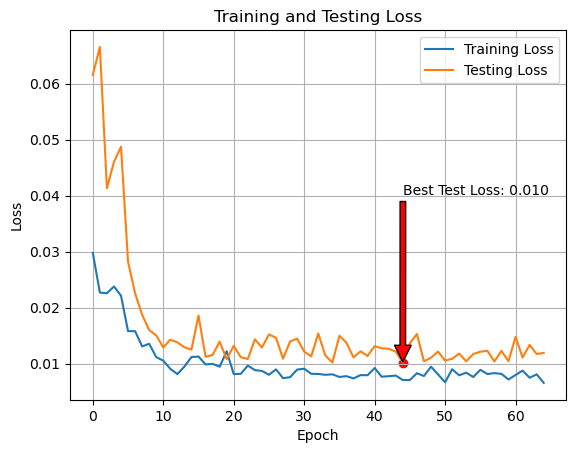

In [189]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)

            # Highlight the best test loss point
plt.scatter(best_epoch, best_test_loss.cpu().numpy(), color='red', label=f'Best Test Loss: {best_test_loss:.2f}')
plt.annotate(f'Best Test Loss: {best_test_loss:.3f}', xy=(best_epoch, best_test_loss), xytext=(best_epoch+0.01, best_test_loss + 0.03),
                        arrowprops=dict(facecolor='red', shrink=0.005))
plt.show()

In [16]:
def prep_data_for_prediction(model, data, window_size, steps, data_start, timeseries_list,device = 'cpu' , covariates=None, covariates_var=None, transformation_covariates_used = None, transformation_covariates_var_used = None, sampling = False):

	# Stride is 1 and not variable in the prediction mode

	stride_size = 1
	# # torch device
	if device == None :
		if torch.cuda.is_available():
			torch.set_default_tensor_type(torch.cuda.FloatTensor)
			device = 'cuda'
		else:
			device = 'cpu'

	# Initial global informations

	time_len = data.shape[0] # time series global lenght
	num_series = data.shape[1] # number of time series
	input_size = window_size-stride_size # Input size

	# Verification for prediction:

	assert steps < window_size, 'The steps='+str(steps)+' is > window_size='+str(window_size)
	assert steps > 0, 'The steps='+str(steps)+' needs to be > 0'

	# if not covariates_var is None :
	# 	assert not transformation_covariates_var_used is None, 'YOU NEED TRANSFMATION FOR THE COVARIATES VAR'
	# 	# Verification of index matching
	# 	assert covariates_var.shape[0] == data.shape[0] + steps, 'covariates_var.shape[0] '+str(covariates_var.shape[0])+' and data.shape[0] + steps '+str(data.shape[0] + steps)+' didn t match'
	# 	# Verification of time series matching
	# 	assert covariates_var.shape[1] == data.shape[1]
	
	if not covariates_var is None : 
		assert not transformation_covariates_var_used is None, 'YOU NEED TRANSFMATION FOR THE COVARIATES VAR'
		# Verification of index matching
		assert covariates_var.shape[0] == data.shape[0] + steps, 'covariates_var.shape[0] '+str(covariates_var.shape[0])+' and data.shape[0] + steps '+str(data.shape[0] + steps)+' didn t match'
		# Verification of time series matching
		assert covariates_var.shape[1] == data.shape[1]

	if not covariates is None :
		assert not transformation_covariates_used is None, 'YOU NEED TRANSFMATION FOR THE COVARIATES'
		# Verification of index matching
		assert covariates.shape[0] == data.shape[0] + steps, 'covariates.shape[0] '+str(covariates.shape[0])+' and data.shape[0] + steps '+str(data.shape[0] + steps)+' didn t match'

	# Append -1 to the new steps to predict to the predict
	# keep only time series with at least one window size

	kept_timeseries = time_len - data_start > window_size
	data = data[:,kept_timeseries]
	data_start = data_start[kept_timeseries]
	covariates_var = None if covariates_var is None else covariates_var[:,kept_timeseries,:]
	timeseries_list = timeseries_list[kept_timeseries]

	# Number of series to predict :
	q = 30
	data = data[:,:q]
	data_start = data_start[:q]
	covariates_var = None if covariates_var is None else covariates_var[:,:q,:]

	# Update the parametres

	time_len = data.shape[0]
	num_series = data.shape[1]

	num_cov_simple = 0 if covariates is None else covariates.shape[1]
	num_cov_var = 0 if covariates_var is None else covariates_var.shape[2]

	num_covariates = num_cov_simple + num_cov_var

	dict_timeseries = dict(zip(timeseries_list,range(num_series)))

	# Number of Windows

	windows_per_series = np.full((num_series), (time_len-input_size) // stride_size) # number of windows in the interval
	windows_per_series -= (data_start+stride_size-1) // stride_size

	# Data structre definition

	total_windows = np.sum(windows_per_series)


	# transformation
	if not covariates_var is None :
		transformation_covariates_var = dict()# np.zeros((num_series,num_cov_var,2)) StandardScaler
	else :
		transformation_covariates_var = None

	if not covariates is None :
		transformation_covariates = dict() #np.zeros((num_series,num_cov_simple,2))
	else :
		transformation_covariates = None

	## Scaling the covariates

	for i in range(num_cov_simple):
		if transformation_covariates_used is None:
			# creating a scaler
			transfomer_cov_simple = StandardScaler()
			covariates[:,i] = transfomer_cov_simple.fit_transform(covariates[:,i].reshape((-1,1)))[:,0]
			transformation_covariates[i] = transfomer_cov_simple
		else :
			# creating a scaler
			transfomer_cov_simple = transformation_covariates_used[i]
			covariates[:,i] = transfomer_cov_simple.fit_transform(covariates[:,i].reshape((-1,1)))[:,0]
			transformation_covariates[i] = transfomer_cov_simple

	# Values assignation
	data = np.append(data, -1*np.ones((steps,num_series)), axis=0) # add the steps to predict
	estimation_model = np.empty((data.shape[0]-1,data.shape[1]))
	sigma_model = np.empty((data.shape[0]-1,data.shape[1]))

	count = 0
	print('# Device :', device)
	for series in range(num_series):
		# ## Scaling the covariate variables
		# if transformation_covariates_var_used is None and not covariates_var is None:
		# 	# creating a scaler
		# 	transfomer_cov_var = StandardScaler()
		# 	covariates_var[data_start[series]:, series,:] = transfomer_cov_var.fit_transform(covariates_var[data_start[series]:, series,:])
		# 	transformation_covariates_var[series] = transfomer_cov_var
		# elif not covariates_var is None:
		# 	# creating a scaler
		# 	transfomer_cov_var = transformation_covariates_var_used[series]
		# 	covariates_var[data_start[series]:, series,:] = transfomer_cov_var.transform(covariates_var[data_start[series]:, series,:])
		# 	transformation_covariates_var[series] = transfomer_cov_var

		# Windows creation
		window_start = data_start[series]
		i = 0

		while stride_size*i + data_start[series] + window_size < time_len + steps - 1 - data_start[series] :  # time_len + steps - 1 to match the new data size - 1
			# In training windowing begun at the start of the time serie

			window_start = stride_size*i + data_start[series]
			window_end = window_start + window_size

			x_input = np.zeros((1, window_size, 1 + num_covariates + 1), dtype='float32')

			# x_input shape is : timeserie_id, steps, timeserie_value+covariate_variables

			x_input[0, :, 0] = data[window_start:window_end, series] # timeserie_value, we start always by 0
			x_input[0, :, 1:1+num_cov_simple] = 0 if num_cov_simple==0 else covariates[window_start + 1:window_end + 1, :] # covariates_values
			x_input[0, :, 1+num_cov_simple:-1] = 0 if num_cov_var == 0 else covariates_var[window_start + 1:window_end + 1, series,:] # covariates than depend on the time serie
			x_input[0, :, -1] = series # timeserie id / label / token which the name is in "timeseries_list"

			# Time serie scale normalization using the window sum

			v_input = np.zeros((1, 2), dtype='float32')

			nonzero_sum = (x_input[0, :, 0]!=0).sum()

			if nonzero_sum == 0:
				v_input[0, 0] = 1
			else:
				v_input[0, 0] = np.true_divide(x_input[0, :, 0].sum(),nonzero_sum)+1
				x_input[0, :, 0] = x_input[0, :, 0]/v_input[0, 0]

			# To tensor
			v_input = torch.tensor(v_input)
			x_input = torch.tensor(x_input)

			# Expanding v_input
			v_input_expanded = v_input.expand(window_size,1,2).transpose(1,0)

			# tocken
			token = np.array([series])
			token = torch.tensor(token)

			# model application
			x_input = x_input[:,:,:-1] # since the token info is given separately

			x_input = x_input.to(device)
			v_input_expanded = v_input_expanded.to(device)
			token = token.to(device)

			if sampling :
				samples, estimation, mu, sigma = evaluate(model, x_input, token, v_input_expanded, window_size, sampling, number_of_samples = 100, scaled_param = True)
			else :
				estimation, mu, sigma = evaluate(model, x_input, token, v_input_expanded, window_size, sampling, number_of_samples = 100, scaled_param = True)

			estimation_model[window_start + 1:window_end + 1, series] = estimation[0,:,0].detach().cpu().numpy()
			sigma_model[window_start + 1:window_end + 1, series] = sigma[0,:,0].detach().cpu().numpy()

			if not window_end < time_len :
				data[window_end,series] = estimation[0,-1,0].detach().cpu().numpy()
			i+=1
			count += 1

	return estimation_model, sigma_model

## Data reading :
Data loaded from : 2018-ET.csv
Data Shape:  (7345, 9)
OG Covariate Shape:  (7345, 5)
# Preparing the data :
test_start_idx: 1550, test_end_idx: 1650, train_end_idx: 1650, all_vals_idx: 1697
test_start: 2022-06-02 07:00:00, test_end: 2022-06-04 09:00:00, train_end: 2022-06-04 09:00:00, all_vals: 2022-06-05 08:30:00
            Temp (Â°C)  Precip. Amount (mm)  Rel Hum (%)  Wind Spd (km/h)  \
timestamp                                                                   
2022-05-01         5.0                  0.0         45.0              7.0   

            Net_Radiation  
timestamp                  
2022-05-01     -62.980341  
Covariates Generation (148, 8) (148, 5)
# Transforming the data :
models//ET_prep/ConvTransformer_ET_prep2024-04-19_13_57_10.883719.pth
# Device : cuda


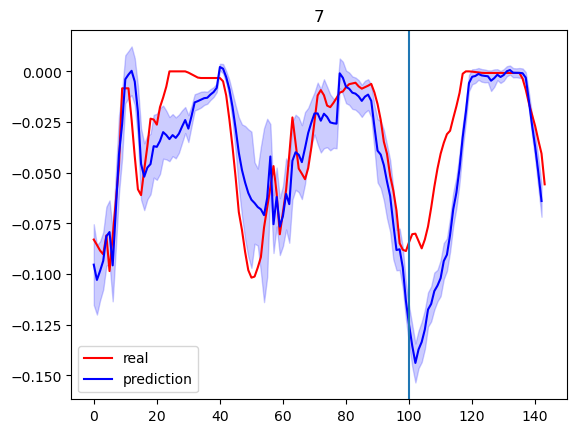

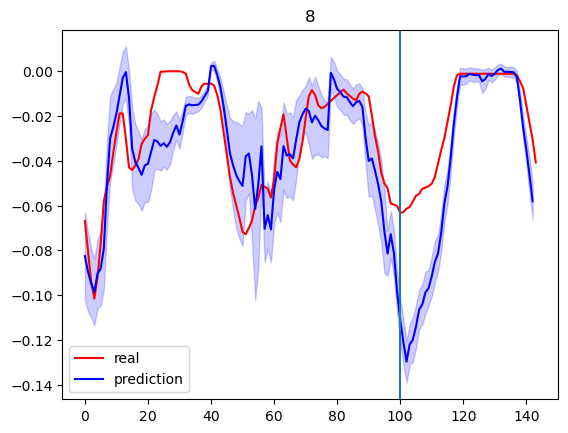

In [226]:
def main_pred(data_path, df_covar ,data_covariates_path, date_column, save_path, prediction_name, model_config_path, meta_information_path, steps, flag_real_plot,test_start_idx, test_end_idx, train_end_idx, all_vals_idx) :
	# model config :
	with open(model_config_path, 'r') as file:
		model_config = json.load(file)

	# Metainformation :
	with open(meta_information_path, 'r') as file:
		meta_information = json.load(file)

	# Covariates and Covariates_var
	with open(meta_information['transformation_covariates_var_path'], 'rb') as file:
		transformation_covariates_var = pickle.load(file)

	with open(meta_information['transformation_covariates'], 'rb') as file:
		transformation_covariates = pickle.load(file)

	flag_covariate = not (transformation_covariates is None)
	flag_covariate_var = False# not (transformation_covariates_var is None)

	if (flag_covariate_var == True ) and (data_covariates_path is None) :
		raise ValueError('Data have a covariates_var and no path to it is gived !')


	# Model Definition :
	window_size = model_config['seq_length']
	number_of_vars = model_config['k']
	num_timeseries_kinds = model_config['num_tokens']

	headers =  model_config['headers']
	depth = model_config['depth']
	kernel_size = model_config['kernel_size']
	PATH = model_config['path']

	train_end = meta_information['train_end']

	#############################################################################

	# Data loading

	print('## Data reading :')
	Table = pd.read_csv(data_path)
	Table.drop(columns=['Unnamed: 0'], inplace=True)
	Table[date_column] = pd.to_datetime(Table[date_column])
	Table.set_index(date_column, inplace=True)
	df_covar.set_index(date_column, inplace=True)
	print('Data loaded from : ' + data_path)
	print('Data Shape: ', Table.shape)
	print('OG Covariate Shape: ', df_covar.shape)

	if data_covariates_path:
		print('## Data covariates reading :')
		covariates_var = []
		for file in os.listdir(data_covariates_path):
			if file.endswith(".csv"):
				if date_column :
					var = pd.read_csv(data_covariates_path+'/'+file)
					var.drop(columns=['Unnamed: 0'], inplace=True)
					var[date_column] = pd.to_datetime(var[date_column])
					var.set_index(date_column, inplace=True)
				else :
					var = pd.read_csv(data_covariates_path+'/'+file, index_col = 0, parse_date=True)
				covariates_var.append(var)
	else :
		covariates_var = None

	print('# Preparing the data :')
	# Train and Test splitfrom pandas.tseries.frequencies import to_offset

	freq = pd.infer_freq(Table.index)
	freq = to_offset(freq)

	#predict starting 

	test_start = Table.index[test_start_idx]   #Table.index[550] 
	test_end = Table.index[test_end_idx]       #Table.index[650]
	train_end = Table.index[train_end_idx]     #Table.index[650]
	all_vals = Table.index[all_vals_idx]       #Table.index[697]
	print(f'test_start_idx: {test_start_idx}, test_end_idx: {test_end_idx}, train_end_idx: {train_end_idx}, all_vals_idx: {all_vals_idx}')
	print(f'test_start: {test_start}, test_end: {test_end}, train_end: {train_end}, all_vals: {all_vals}')

	# List of time series
	timeseries_list = np.array(list(Table.columns))

	# covariate variables preparation
	test_data = Table[test_start:test_end].values
	tst_index = Table[test_start:test_end].index

	if not covariates_var is None : 
		test_covariates_var = []
		for var in covariates_var :
			assert (tst_index.union([tst_index[-1] + i*freq for i in range(steps+1)]) == var[test_start:test_end+steps*freq].index).all(), 'The covariate var '+str(var)+' didn t much steps for prediction : '+str(tst_index.union([tst_index[-1] + i*freq for i in range(steps+1)]))+' != '+str(var.index[test_start:test_end+steps*freq])
			test_covariates_var.append(var[test_start:test_end+steps*freq].values[:,:,None])
		test_covariates_var = np.concatenate(test_covariates_var,axis=2)
	else :
		test_covariates_var = None

	## Test
	print(df_covar.head(1))
	freq = pd.infer_freq(tst_index)
	freq = to_offset(freq)
	#print('Covar: Shape: ',df_covar[test_start_idx-1:all_vals_idx].shape)
	#print(test_start_idx-1,all_vals_idx)
	#print('Covar: start and end date: ',df_covar[test_start_idx].index, df_covar[all_vals_idx+1].index)
	all_values = [tst_index[-1] + i*freq for i in range(steps+1)]
	if flag_covariate :
		#covariates_test = gen_covariates(df_covar[test_start:test_start_idx:all_values],tst_index.union([tst_index[-1] + i*freq for i in range(steps+1)]))
		covariates_test = gen_covariates(df_covar[test_start:all_vals],tst_index.union([tst_index[-1] + i*freq for i in range(steps+1)]))
	else :
		covariates_test = False

	# data_start
	data_start_test = (test_data!=0).argmax(axis=0) #find first nonzero value in each time series

	# Apply the transformation
	print('# Transforming the data :')
	window_size_test = window_size

	device = 'cpu'
	if torch.cuda.is_available():
		torch.set_default_tensor_type(torch.cuda.FloatTensor)
		device = 'cuda'

	###################

	# Model 
	model = ForcastConvTransformer(k = number_of_vars, headers=headers, depth=depth, seq_length=window_size, kernel_size=kernel_size, num_tokens=num_timeseries_kinds)
	#####################
	print(PATH)
	checkpoint = torch.load(PATH)
	model.load_state_dict(checkpoint['model_state_dict'])
	model.eval()

	estimation, sigma = prep_data_for_prediction(model, test_data, window_size_test, steps=steps, data_start=data_start_test, timeseries_list=timeseries_list,device = 'cuda', covariates=covariates_test, covariates_var=test_covariates_var,transformation_covariates_used = transformation_covariates, transformation_covariates_var_used = transformation_covariates_var, sampling = False)

	pt = os.path.join(save_path, prediction_name)
	os.makedirs(pt, exist_ok = True)

	np.save(pt+'/estimation.npy',estimation)
	np.save(pt+'/sigma.npy',sigma)


	# show a plot
	temp = Table[test_start:all_vals]
	m= np.random.randint(0,estimation.shape[1])
	if True:#flag_real_plot:
		plt.plot(temp.iloc[4:,m].values,label='real', c='red')
	plt.plot(estimation[4:,m], label='prediction', c='b')

	under_line = estimation[4:,m] - sigma[4:,m]
	over_line = estimation[4:,m] + sigma[4:,m]
	plt.fill_between(range(len(estimation[4:,m])),under_line, over_line, color='b', alpha=0.2) #std curves.
	separation = (100)
	plt.axvline(separation)

	plt.legend()
	plt.title(m)
	plt.show()
	
	#save all the plots
	for m in range(estimation.shape[1]):
		plt.close()
		if True:
			plt.plot(temp.iloc[4:,m].values,label='real', c='red')
		plt.plot(estimation[4:,m], label='prediction', c='b')

		under_line = estimation[4:,m] - sigma[4:,m]
		over_line = estimation[4:,m] + sigma[4:,m]
		plt.fill_between(range(len(estimation[4:,m])),under_line, over_line, color='b', alpha=0.2) #std curves.

		separation = (100)
		plt.axvline(separation)

		plt.legend()
		plt.title(m)
		plt.savefig(pt+'/'+str(m)+'.png')

steps = 47
test_start_idx = 1550 # feed in any series of data
test_end_idx = 1650 # Any interval greater than window size
train_end_idx = 1650
all_vals_idx = train_end_idx + steps
date_column = 'timestamp'
cast_float16 = False
covariatesOG = covariatesOG1.copy()
data_path = '2018-ET.csv'
save_path = 'predictions'
meta_information_path  = 'data_prepared/ET_prep/meta_information.json'
model_config_path  = 'models/ET_prep/model_config.json'
prediction_name = '01'
flag_real_plot = False
data_covariates_path = None #'prep_covar'

main_pred(data_path, covariatesOG, data_covariates_path, date_column, save_path, prediction_name, model_config_path, meta_information_path, steps, flag_real_plot,test_start_idx, test_end_idx, train_end_idx, all_vals_idx)

-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x Model Completed x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x-x

# Results

In [227]:
Table = pd.read_csv('2018-ET.csv')
Table.drop(columns=['Unnamed: 0'], inplace=True)
Table[date_column] = pd.to_datetime(Table[date_column])
Table.set_index(date_column, inplace=True)
temp = Table[Table.index[300]:Table.index[446]]
print(temp.shape)

estimation = np.load('predictions/01/estimation.npy')
print(estimation.shape)
df = pd.DataFrame(estimation)
df.columns = list(temp.columns)

sigma = np.load('predictions/01/sigma.npy')
# print(sigma.shape)
# sigma = pd.DataFrame(sigma)
# sigma.columns = list(temp.columns)
# sigma

(147, 9)
(147, 9)


In [228]:
df=df.apply(pd.to_numeric)

In [217]:
from sklearn.metrics import mean_squared_error
temp = temp.tail(47)
df = df.tail(47)

mse_values = {}
columns_to_compare =list(temp.columns)
for column in columns_to_compare:
    mse_values[column] = mean_squared_error(temp[column], df[column])

for column, mse in mse_values.items():
    print(f"MSE for {column}: {mse}")

overall_mse = sum(mse_values.values()) / len(mse_values)
print(f"Overall MSE: {overall_mse}")

MSE for H1L1: 0.019562803856931887
MSE for H1L2: 0.0005897212939506984
MSE for H1L6: 0.0039687041100924395
MSE for H2L1: 0.001016209234471353
MSE for H2L3: 0.00026389910719517754
MSE for H2L5: 0.001392204365446331
MSE for H3L2: 0.0007337590729984157
MSE for H3L3: 0.0009630172888000638
MSE for H3L4: 0.0005546795153668679
Overall MSE: 0.0032272219828059145


In [218]:
from sklearn.metrics import mean_absolute_error
mae_values = {}
columns_to_compare =list(temp.columns)
for column in columns_to_compare:
    mae_values[column] = mean_absolute_error(temp[column], df[column])

for column, mse in mae_values.items():
    print(f"MAE for {column}: {mse}")

overall_mse = sum(mae_values.values()) / len(mae_values)
print(f"Overall MAE: {overall_mse}")

MAE for H1L1: 0.1142605748035847
MAE for H1L2: 0.0207814277839288
MAE for H1L6: 0.05261903240551202
MAE for H2L1: 0.028430653237175998
MAE for H2L3: 0.013677276995307545
MAE for H2L5: 0.03159279953870256
MAE for H3L2: 0.022729199272675193
MAE for H3L3: 0.02576193310389435
MAE for H3L4: 0.019747637244009627
Overall MAE: 0.03662228159831009


Prediction boxplot

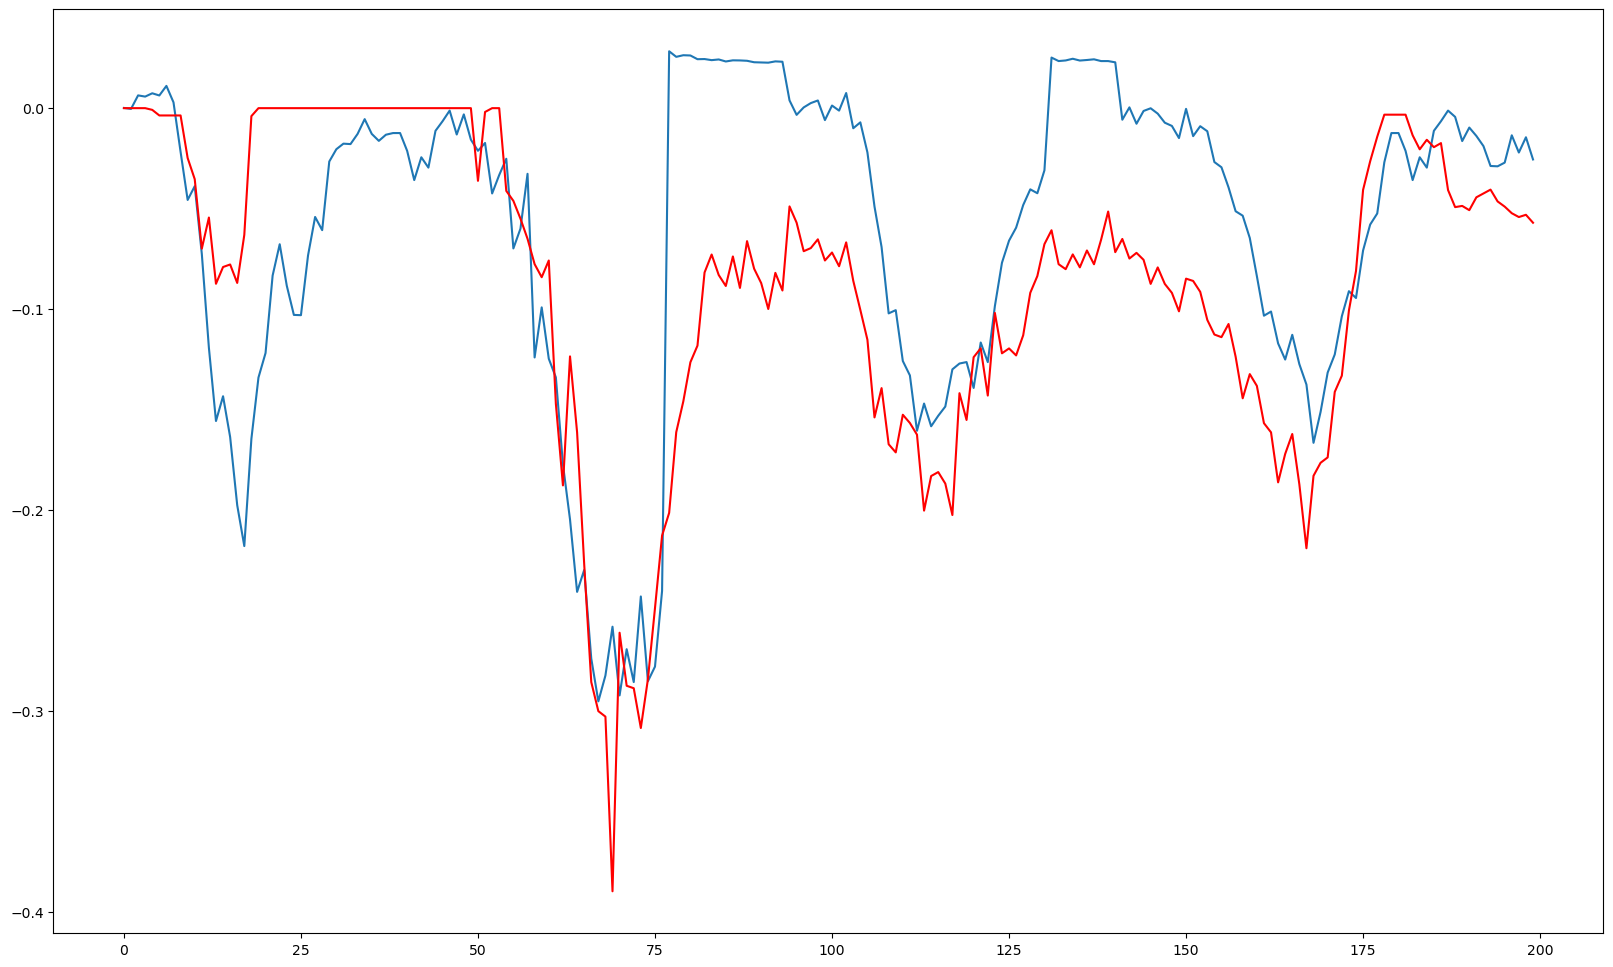

In [243]:
df = pd.read_csv('100indxstart.csv')
temp = pd.read_csv('unsmooth-2018-ET.csv').iloc[100:3155,:]
temp.reset_index(inplace=True)
plt.figure(figsize=(20,12))
plt.plot(df['H1L1'][:200])
plt.plot(temp['H1L1'][:200],color = 'red')
plt.show()

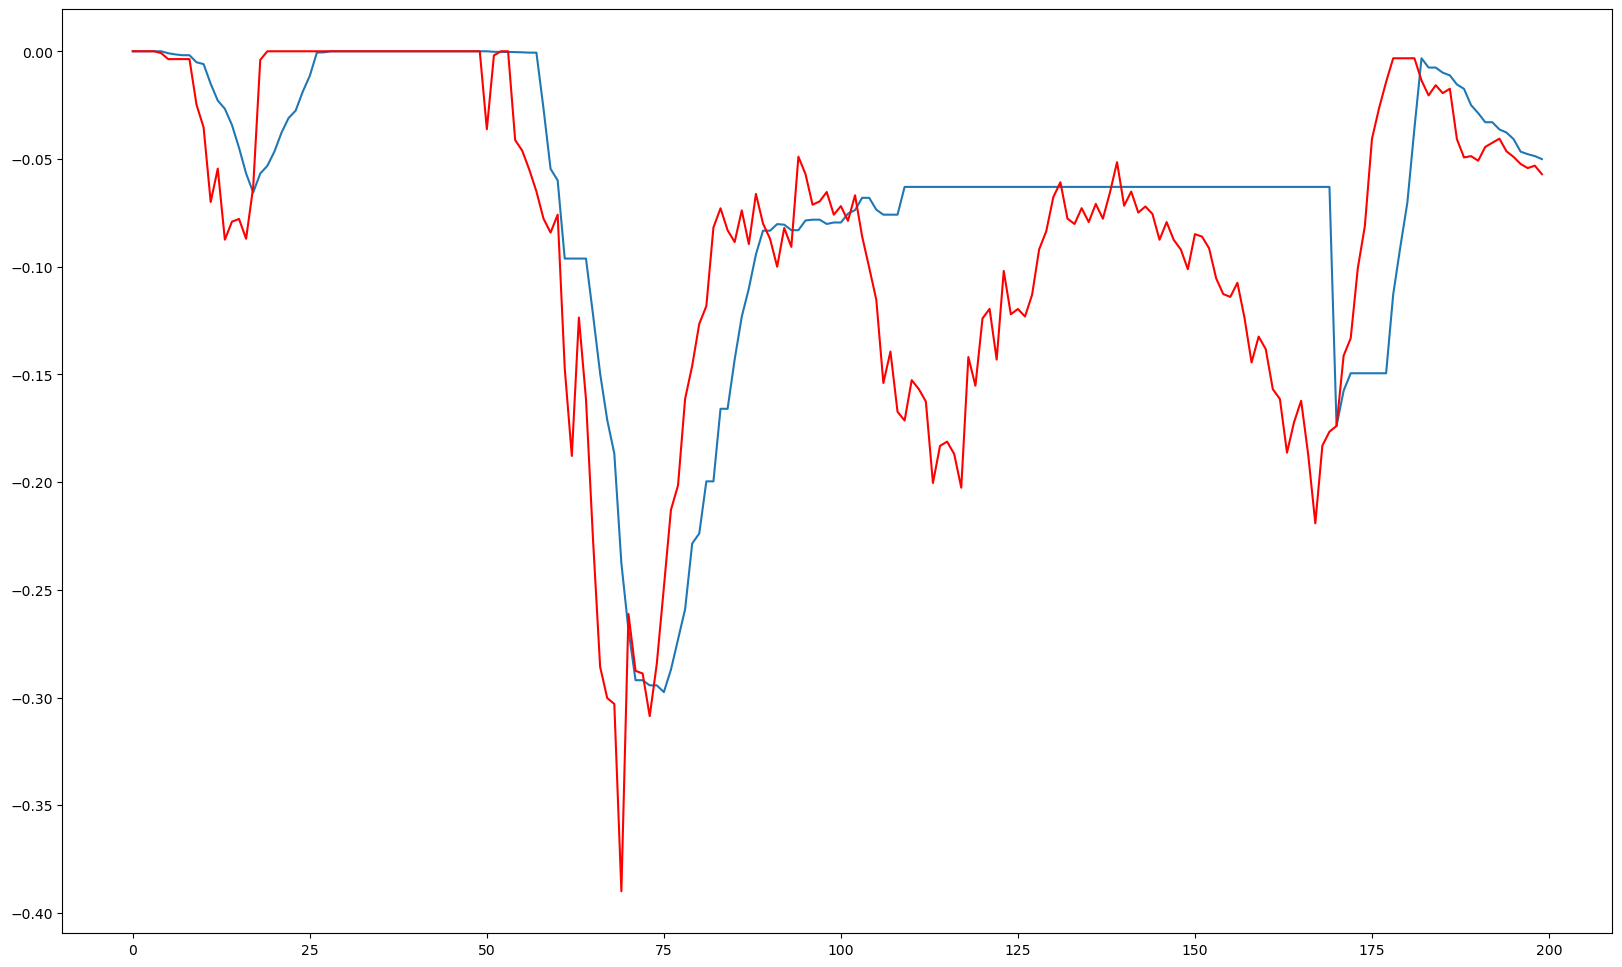

In [281]:
plt.figure(figsize=(20,12))
plt.plot(no_null['H1L1'][:200])
plt.plot(temp['H1L1'][:200],color = 'red')
plt.show()

Good Visuals

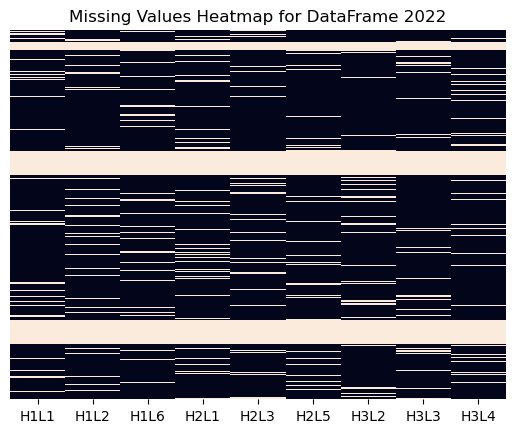

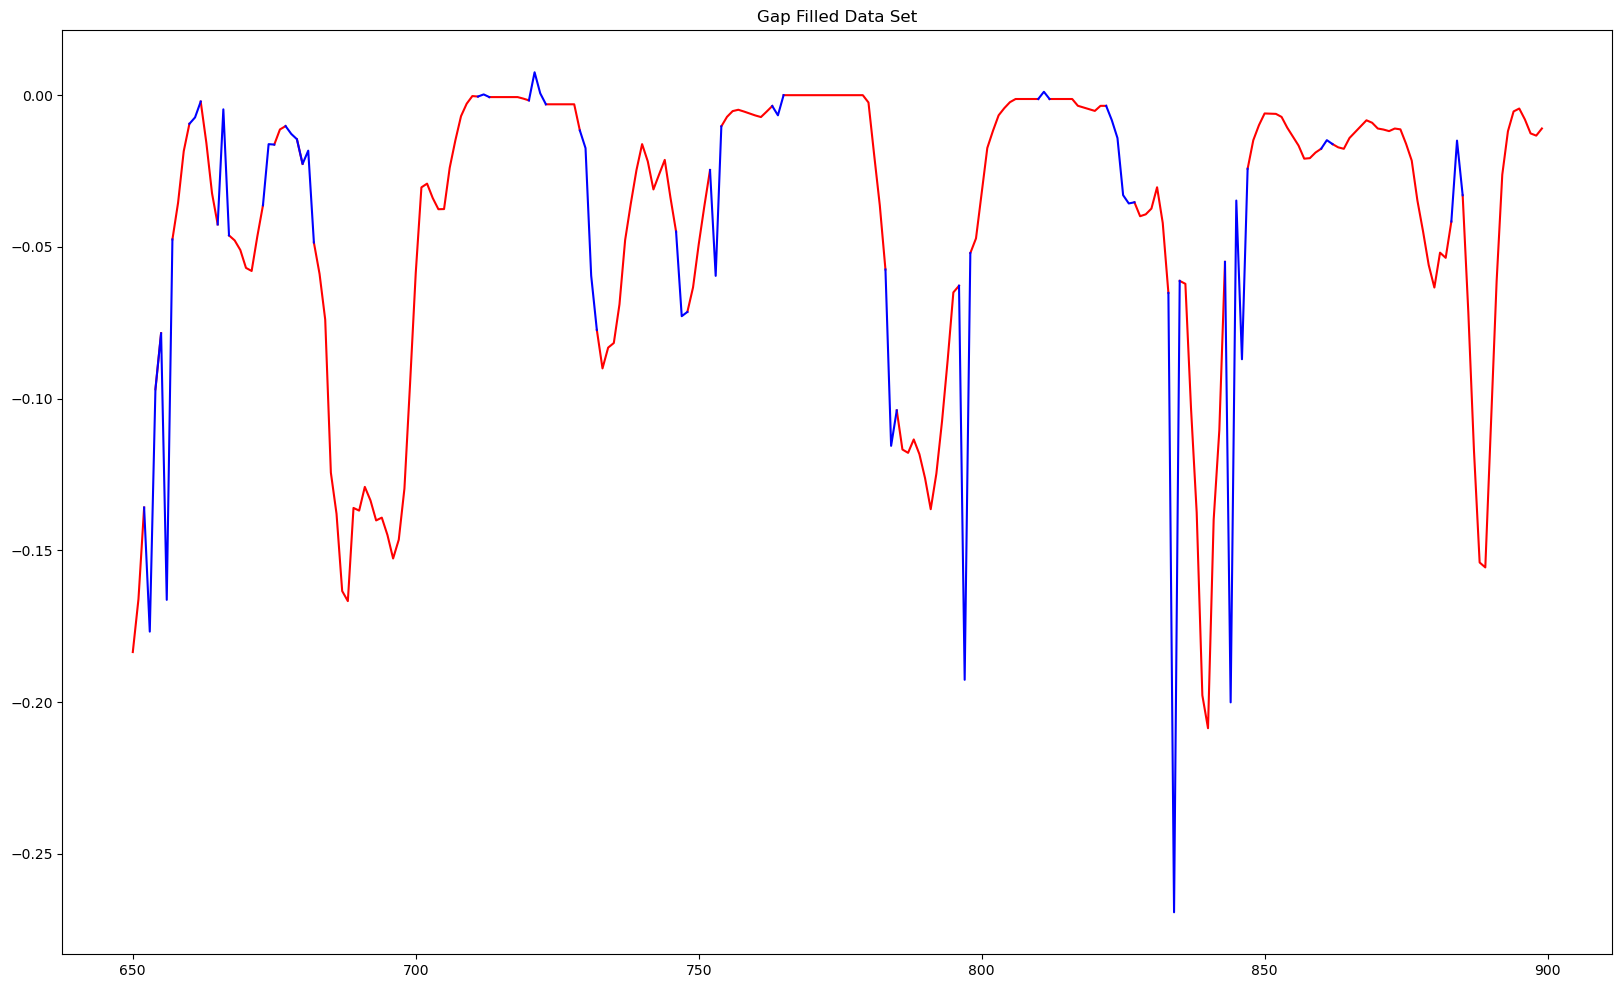

In [7]:
feats = ['H1L1', 'H1L2', 'H1L6', 'H2L1', 'H2L3', 'H2L5', 'H3L2', 'H3L3', 'H3L4']
temp = pd.read_csv('2018-ET.csv').iloc[100:3155,:]
temp.reset_index(inplace=True)
null_percentage = 0.1
null_count = int(null_percentage * temp.size)

# Create a mask where 16% of the values are True
mask = np.full(temp.shape, False)
mask[np.random.choice(temp.shape[0], null_count, replace=True), np.random.choice(temp.shape[1], null_count, replace=True)] = True

# Set the values indicated by the mask to null
df_with_nulls = temp.mask(mask)
df_with_nulls.iloc[1000:1200,:] = np.nan
df_with_nulls.iloc[100:170,:] = np.nan
df_with_nulls.iloc[2400:2600,:] = np.nan
df_with_nulls = df_with_nulls[feats]

sns.heatmap(df_with_nulls.isnull(), yticklabels=False, cbar=False)
plt.title(f"Missing Values Heatmap for DataFrame 2022")
plt.show()
df = pd.read_csv('100indxstart.csv')

df[df_with_nulls.notnull()] = np.nan

null_indices = df_with_nulls.isnull()
adjacent_null_values = (null_indices.shift(1) | null_indices.shift(-1)).fillna(False)
adj = df_with_nulls[adjacent_null_values]
df.fillna(adj,inplace=True) #= df_with_nulls[adjacent_null_values]


plt.figure(figsize=(16,8))
plt.plot(df_with_nulls['H1L1'][650:900],color = 'red')
plt.plot(df['H1L1'][650:900],color='blue')
#plt.scatter(df['H1L1'][650:900].index,df['H1L1'][650:900],color='blue', marker='x', label='Imputed',s=50)
plt.title('Gap Filled Data Set with Conv. Transformer Model Output')
plt.show()

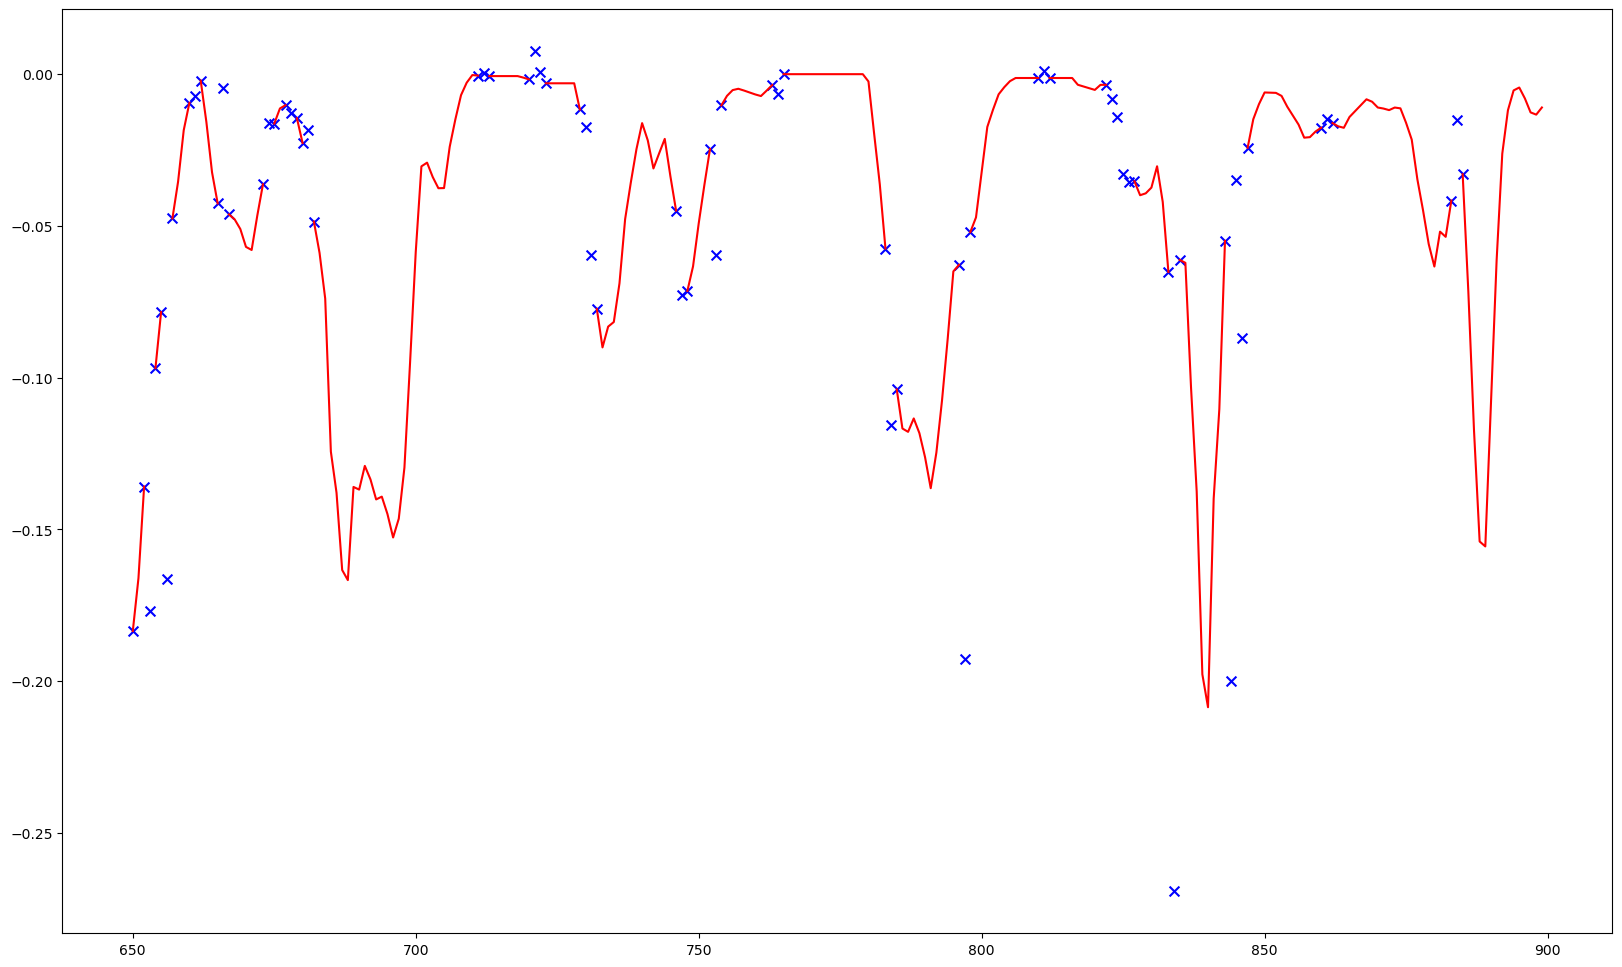

In [10]:
plt.figure(figsize=(20,12))

plt.plot(df_with_nulls['H1L1'][650:900],color = 'red')
plt.scatter(df['H1L1'][650:900].index,df['H1L1'][650:900],color='blue', marker='x', label='Imputed',s=50)